# Scenario Analysis

This notebook merges the analysis from several PyPSA-Network runs to provide a comprehensive overview and comparison of different scenarios.

**Scenarios Analyzed:**
- *Scenario A: [Brief Description]*
- *Scenario B: [Brief Description]*
- *Scenario C: [Brief Description]*

---

## 1. Setup and Data Loading

*This section handles the initial setup, including importing necessary libraries and loading the solved PyPSA network data for each scenario.*

### 1.1. Import Libraries

In [ ]:
!pip install plotly -qq

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pycountry
import yaml

import pypsa
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches

import cartopy.crs as ccrs # For plotting maps
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import box
from matplotlib.offsetbox import AnnotationBbox, AuxTransformBox
from matplotlib.patches import Wedge
import matplotlib.path as mpath
import matplotlib.transforms as mtransforms
import matplotlib.lines as mlines
from matplotlib.legend_handler import HandlerPatch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import plotly.express as px
import plotly.graph_objects as go

from shapely.geometry import LineString
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

import warnings
warnings.filterwarnings("ignore")



<!-- ### 1.2. Load Solved Network(s) -->

In [17]:
scenario_list = [1, 2, 6, 10] # 3, 4, 5] # List of scenarios to analyze
horizon_list = [2030, ] # List of horizons to analyze

networks = {}

results_dir = os.path.join(os.getcwd(), 'results')

# # Load Base scenario
# base_path = os.path.join(results_dir, 'US_base_year', "elec_s_100_ec_lcopt_Co2L-3H_3H_2020_0.071_AB_10export.nc")
# networks['base_scenario'] = pypsa.Network(base_path)

# Load networks for each scenario and horizon
for i in scenario_list:
    scenario_dir = f"US_scenario_{i:02d}"
    postnetworks_dir = os.path.join(results_dir, scenario_dir, "postnetworks")
    for horizon in horizon_list:
        # Construct the file path based on scenario and horizon
        file_path = os.path.join(postnetworks_dir, f'elec_s_100_ec_lcopt_3H_3H_{horizon}_0.071_AB_10export.nc')
        
        # Load the network
        networks[f'scenario_{i:02d}_{horizon}'] = pypsa.Network(file_path)

network_names = list(networks.keys())

INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_3H_3H_2030_0.071_AB_10export.nc has buses, carriers, generators, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_3H_3H_2030_0.071_AB_10export.nc has buses, carriers, generators, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_3H_3H_2030_0.071_AB_10export.nc has buses, carriers, generators, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_3H_3H_2030_0.071_AB_10export.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


In [18]:
# region_shapes_path = "/Users/gbotemi/Documents/code/PYPSA/US/efuels-supply-potentials/needs_grid_regions_aggregated.geojson"
region_shapes_path = "/Users/gbotemi/Documents/code/PYPSA/US/NEEDS_grid_regions/needs_grid_regions_aggregated.shp"
state_shapes_path = "/Users/gbotemi/Documents/code/PYPSA/US/efuels-supply-potentials/data/validation/gadm41_USA_1.json"

In [19]:
with open('plotting.yaml', 'r') as file:
    plotting = yaml.safe_load(file)

In [20]:
plotting.keys()

dict_keys(['tech_colors', 'nice_names', 'rename_tech', 'renamed_tech_colors'])

In [21]:
tech_colors = plotting['tech_colors']
nice_names = plotting['nice_names']

In [22]:
def attach_region_to_buses(network, path_shapes, distance_crs="EPSG:4326"):
    """
    Attach region to buses
    """
    # Read the shapefile using geopandas
    shapes = gpd.read_file(path_shapes, crs=distance_crs)
    shapes.rename(columns={"GRID_REGIO": "Region"}, inplace=True)

    ac_dc_carriers = ["AC", "DC"]
    location_mapping = network.buses.query("carrier in @ac_dc_carriers")[["x", "y"]]

    network.buses["x"] = network.buses["location"].map(location_mapping["x"]).fillna(0)
    network.buses["y"] = network.buses["location"].map(location_mapping["y"]).fillna(0)
    
    pypsa_gpd = gpd.GeoDataFrame(
            network.buses, 
            geometry=gpd.points_from_xy(network.buses.x, network.buses.y), 
            crs=4326
        )

    bus_cols = network.buses.columns
    bus_cols = list(bus_cols) + ["region"]

    st_buses = gpd.sjoin_nearest(shapes, pypsa_gpd, how="right")

    network.buses["region"] = st_buses["Region"]

    return network

def attach_state_to_buses(network, path_shapes, distance_crs="EPSG:4326"):
    """
    Attach state to buses
    """
    # Read the shapefile using geopandas
    shapes = gpd.read_file(path_shapes, crs=distance_crs)
    shapes["ISO_1"] = shapes["ISO_1"].apply(lambda x: x.split("-")[1])
    shapes.rename(columns={"ISO_1": "State"}, inplace=True)

    ac_dc_carriers = ["AC", "DC"]
    location_mapping = network.buses.query("carrier in @ac_dc_carriers")[["x", "y"]]

    network.buses["x"] = network.buses["location"].map(location_mapping["x"]).fillna(0)
    network.buses["y"] = network.buses["location"].map(location_mapping["y"]).fillna(0)
    
    pypsa_gpd = gpd.GeoDataFrame(
            network.buses, 
            geometry=gpd.points_from_xy(network.buses.x, network.buses.y), 
            crs=4326
        )

    bus_cols = network.buses.columns
    bus_cols = list(bus_cols) + ["State"]

    st_buses = gpd.sjoin_nearest(shapes, pypsa_gpd, how="right")

    network.buses["state"] = st_buses["State"]

    return network

In [23]:
for network in networks.keys():
    networks[network] = attach_region_to_buses(networks[network], region_shapes_path)
    networks[network] = attach_state_to_buses(networks[network], state_shapes_path)

---

## 2. Input Data Analysis & Validation

*Before diving into results, we validate and visualize the key input data that drives the model. This primarily focuses on electricity demand.*

### 2.1. Demand Projections & Overview
*A summary of the overall demand assumptions for the model years.*

In [ ]:
# Code to extract and display demand assumptions
# e.g., total annual TWh demand per country
pass

### 2.2. Country-wise Total Electricity Demand (Time Series)
*This plot shows the electricity demand profile over the year for each country, which is a primary driver for the system's operation.*

In [ ]:
# networks.keys()

dict_keys(['Base Scenario', 'Scenario A', 'Scenario B'])

In [ ]:
# target_processes = [
#     "SMR CC", "Haber-Bosch", "ethanol from starch", "ethanol from starch CC",
#     "DRI", "DRI CC", "DRI H2", "BF-BOF", "BF-BOF CC", "EAF",
#     "dry clinker", "cement finishing", "dry clinker CC"
# ]
# static_load_carriers = ["rail transport electricity", "agriculture electricity", "industry electricity"]
# dynamic_load_carriers = ["AC", "services electricity", "land transport EV"]

# demand = pd.DataFrame(columns=networks.keys(), index=dynamic_load_carriers+static_load_carriers+["total demand"])
# demand_profile = pd.DataFrame(columns=networks.keys(), index=networks["Base Scenario"].snapshots)
# ac_load, services_load, ev_load = 0, 0, 0

# for name, n in networks.items():

#     # calculate static loads and its profile
#     nhours = n.snapshot_weightings.objective.sum()
#     static_totals = (
#         n.loads.groupby("carrier")
#             .sum().p_set
#             .reindex(static_load_carriers)
#             .fillna(0)
#     )
#     static_load_twh = static_totals.sum() * nhours / 1e6

#     process_links = n.links[n.links.carrier.isin(target_processes)]
#     ac_input_links = process_links[process_links.bus0.map(n.buses.carrier) == "AC"].index

#     ind_ac_profile = n.links_t.p0[ac_input_links].sum(axis=1)
#     ind_ac_twh = (ind_ac_profile * n.snapshot_weightings.objective).sum() / 1e6

#     ac_loads = n.loads[n.loads.carrier == "AC"]
#     industrial_ac_buses = n.links.loc[ac_input_links, "bus0"].unique()
#     ac_non_ind_idx = ac_loads[~ac_loads.bus.isin(industrial_ac_buses)].index
#     ac_profile = n.loads_t.p_set[ac_non_ind_idx.intersection(n.loads_t.p_set.columns)].sum(axis=1)
#     ac_twh = (ac_profile * n.snapshot_weightings.objective).sum() / 1e6 - ind_ac_twh

#     # calculate dynamic loads and profiles
#     # ac_loads = n.loads.query("carrier in 'AC'").index
#     # ac_profile = n.loads_t.p_set[ac_loads].sum(axis=1)
#     # ac_load = ac_profile.multiply(n.snapshot_weightings.objective, axis=0).sum() / 1e6

#     # 3. Services & EV
#     serv_idx = [i for i in n.loads[n.loads.carrier == "services electricity"].index
#                 if i in n.loads_t.p_set.columns]
#     ev_idx   = [i for i in n.loads[n.loads.carrier == "land transport EV"].index
#                 if i in n.loads_t.p_set.columns]

#     serv_profile = n.loads_t.p_set[serv_idx].sum(axis=1) if serv_idx else 0
#     ev_profile   = n.loads_t.p_set[ev_idx].sum(axis=1)   if ev_idx else 0

#     serv_twh = (serv_profile * n.snapshot_weightings.objective).sum() / 1e6
#     ev_twh   = (ev_profile   * n.snapshot_weightings.objective).sum() / 1e6

#     # 4. Industry electricity total = static + industrial AC
#     industry_static_twh = static_totals.get("industry electricity", 0) * nhours / 1e6
#     industry_elec_twh = industry_static_twh + ind_ac_twh

#     dynamic_profile = ac_profile + serv_profile + ev_profile
#     demand_profile.loc[:, name] = dynamic_profile + static_totals.sum()

#     demand.loc["rail transport electricity", name] = static_totals.get("rail transport electricity", 0) * nhours / 1e6
#     demand.loc["agriculture electricity",      name] = static_totals.get("agriculture electricity",  0) * nhours / 1e6
#     demand.loc["industry electricity",         name] = industry_elec_twh
#     demand.loc["AC",                           name] = ac_twh
#     demand.loc["services electricity",         name] = serv_twh
#     demand.loc["land transport EV",            name] = ev_twh
#     demand.loc["total demand",                 name] = (
#         static_load_twh + ac_twh + ind_ac_twh + serv_twh + ev_twh
#     )


In [ ]:
# demand

Base Scenario   Scenario A   Scenario B
AC                           1334.056044  1490.519908  1630.208261
services electricity         1378.710858  1386.508012  1457.414215
land transport EV              66.179636   398.649193   918.764229
rail transport electricity        7.3338       5.5476       5.5476
agriculture electricity          75.2058      57.3213      57.3213
industry electricity          737.610795   886.717069   981.953359
total demand                 3599.096933  4225.263082  5051.208964

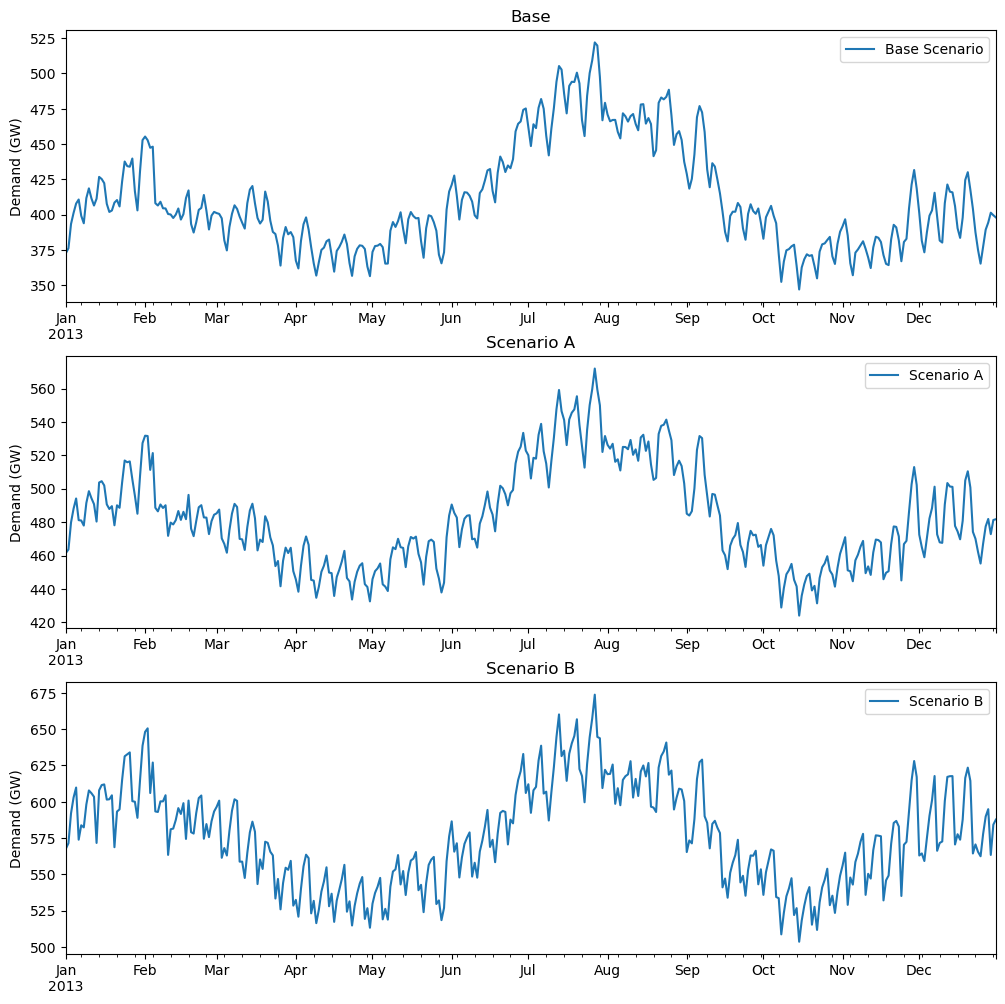

In [ ]:
# fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,12))
# (demand_profile.filter(like="Base")/1e3).plot(ax=axes[0])
# (demand_profile.filter(like="Scenario A")/1e3).plot(ax=axes[1])
# (demand_profile.filter(like="Scenario B")/1e3).plot(ax=axes[2])

# for ax, y in zip(axes, ['Base', "Scenario A", "Scenario B"]):
#     ax.set_ylabel("Demand (GW)")
#     ax.legend()
#     ax.set_xlabel(None)
#     ax.set_title(y)


### 2.3. State-wise Total Electricity Demand (Validation Year)
*A bar plot showing the total annual electricity demand for each state or region for the validation year. This helps confirm the spatial distribution of demand.*

In [ ]:
# def compute_demand(network):
#     """
#     Compute total demand by region and by state
#     """
#     n = attach_region_to_buses(network, region_shapes_path)
#     n = attach_state_to_buses(network, state_shapes_path)

#     ac_loads = n.loads.query("carrier in 'AC'").index
#     ac_profile = n.loads_t.p_set[ac_loads].multiply(n.snapshot_weightings.objective, axis=0).sum() / 1e6
#     ac_load_bus = ac_profile.to_frame().reset_index().rename(columns={0: "load", "Load": "region"})
#     ac_load_bus["carrier"] = "AC"

#     nhours = n.snapshot_weightings.objective.sum()
#     static_load = n.loads.groupby(["bus", "carrier"]).sum()[["p_set"]].reset_index()
#     static_load_bus = static_load.query("carrier in @static_load_carriers").reset_index(drop=True)
#     static_load_bus['p_set'] = static_load_bus.p_set * nhours / 1e6

#     services_profile = n.loads_t.p_set.filter(like="services electricity") / 1e6
#     services_load = services_profile.multiply(n.snapshot_weightings.objective, axis=0).sum().to_frame().reset_index().rename(columns={0: "services electricity load", "Load": "bus"})
#     services_load["region"] = services_load["bus"].str.extract(r"(US\d{1} \d{1,2})")
#     services_load.rename(columns={"services electricity load": "load"}, inplace=True)
#     services_load["carrier"] = "services electricity"

#     static_load_bus["region"] = static_load_bus["bus"].str.extract(r"(US\d{1} \d{1,2})")
#     agriculture_electricity_load = static_load_bus.query("carrier == 'agriculture electricity'")
#     agriculture_electricity_load.rename(columns={"p_set": "load"}, inplace=True)

#     industry_electricity_load = static_load_bus.query("carrier == 'industry electricity'")
#     industry_electricity_load.rename(columns={"p_set": "load"}, inplace=True)

#     rail_transport_electricity_load = static_load_bus.query("carrier == 'rail transport electricity'")
#     rail_transport_electricity_load.rename(columns={"p_set": "load"}, inplace=True)

#     ev_profile = n.loads_t.p_set.filter(like="land transport EV")
#     ev_load = (ev_profile.multiply(n.snapshot_weightings.objective, axis=0).sum() / 1e6).to_frame().reset_index().rename(columns={0: "load", "Load": "bus"})
#     ev_load["region"] = ev_load["bus"].str.extract(r"(US\d{1} \d{1,2})")
#     ev_load["carrier"] = "land transport EV"

#     all_loads = pd.concat([ac_load_bus, ev_load, services_load, agriculture_electricity_load, industry_electricity_load, rail_transport_electricity_load], axis=0)

#     all_loads_df_region = all_loads.pivot(index="region", columns="carrier", values="load").fillna(0).round(2)
#     all_loads_df_region.index = all_loads_df_region.index.map(n.buses.region)
#     all_loads_df_region_sum = all_loads_df_region.groupby("region").sum()

#     all_loads_df_state = all_loads.pivot(index="region", columns="carrier", values="load").fillna(0).round(2)
#     all_loads_df_state.index = all_loads_df_state.index.map(n.buses.state)
#     all_loads_df_state_sum = all_loads_df_state.groupby("region").sum()

#     return all_loads_df_region_sum, all_loads_df_state_sum


In [ ]:
# base_demand_region, base_demand_state = compute_demand(n_base)

In [ ]:
# base_demand_region

carrier           AC  agriculture electricity  industry electricity  \
region                                                                
California    134.28                    10.74                 81.84   
Delta         120.86                     4.79                 63.20   
Mid-Atlantic  190.78                     8.79                 67.72   
Midwest       261.90                    12.59                112.98   
Mountain       64.41                     3.52                 28.32   
New England     0.00                     0.01                  0.08   
New York      178.26                    12.93                140.53   
Northwest      66.32                     5.18                 37.90   
Southeast     182.67                     8.73                 47.52   
Texas         206.52                     7.93                 85.60   

carrier       land transport EV  rail transport electricity  \
region                                                        
California                 0.00                        1.05   
Delta                      5.56                        0.47   
Mid-Atlantic              10.41                        0.86   
Midwest                   15.34                        1.23   
Mountain                   0.00                        0.34   
New England                0.01                        0.00   
New York                  15.76                        1.26   
Northwest                  0.00                        0.50   
Southeast                  9.97                        0.85   
Texas                      9.13                        0.77   

carrier       services electricity  
region                              
California                  131.68  
Delta                       118.52  
Mid-Atlantic                187.08  
Midwest                     256.81  
Mountain                     63.16  
New England                   0.00  
New York                    174.80  
Northwest                    65.03  
Southeast                   179.12  
Texas                       202.52

In [ ]:
# base_demand_state

carrier      AC  agriculture electricity  industry electricity  \
region                                                           
AR       120.86                     4.79                 63.20   
CA       134.28                    10.74                 81.84   
GA       182.67                     8.73                 47.52   
IA        88.86                     4.00                 35.47   
IN       173.04                     8.59                 77.51   
NH         0.00                     0.01                  0.08   
NY       178.26                    12.93                140.53   
OR        66.32                     5.18                 37.90   
TX       206.52                     7.93                 85.60   
WV       190.78                     8.79                 67.72   
WY        64.41                     3.52                 28.32   

carrier  land transport EV  rail transport electricity  services electricity  
region                                                                        
AR                    5.56                        0.47                118.52  
CA                    0.00                        1.05                131.68  
GA                    9.97                        0.85                179.12  
IA                    4.89                        0.39                 87.13  
IN                   10.45                        0.84                169.68  
NH                    0.01                        0.00                  0.00  
NY                   15.76                        1.26                174.80  
OR                    0.00                        0.50                 65.03  
TX                    9.13                        0.77                202.52  
WV                   10.41                        0.86                187.08  
WY                    0.00                        0.34                 63.16

In [ ]:
# fig1 = px.bar(base_demand_region, barmode='stack', text_auto='.1f')
# fig1.update_layout(width=1000, yaxis_title='Demand (TWh)', xaxis_title='Region', title='Electricity Demand by Carrier and Region (2023)')
# fig1.show()

# fig1 = px.bar(base_demand_state, barmode='stack', text_auto='.1f')
# fig1.update_layout(width=1000, yaxis_title='Demand (TWh)', xaxis_title='State', title='Electricity Demand by Carrier and State (2023)')
# fig1.show()

### 2.4. Data Center Loads/Demands
*Isolating and visualizing the specific demand profile of data centers to understand their impact on the system.*

In [ ]:
# def compute_data_center_load(network):
#     """
#     Compute data center load by region and by state
#     """

#     data_center_loads = network.loads.query("carrier in 'data center'")

#     data_center_loads["region"] = data_center_loads.bus.map(network.buses.region)
#     data_center_loads["state"] = data_center_loads.bus.map(network.buses.state)

#     return data_center_loads

In [ ]:
# data_center_df_region = pd.DataFrame()
# data_center_df_state = pd.DataFrame()

# for idx, network in enumerate(networks.keys()):
#     data_center_load = compute_data_center_load(networks[network])
#     data_center_load_grouped_region = data_center_load.groupby("region")[['p_set']].sum().rename(columns={"p_set": network_names[idx]})
#     data_center_load_grouped_state = data_center_load.groupby("state")[['p_set']].sum().rename(columns={"p_set": network_names[idx]})
#     data_center_df_region = data_center_df_region.join(data_center_load_grouped_region, how='outer')
#     data_center_df_state = data_center_df_state.join(data_center_load_grouped_state, how='outer')



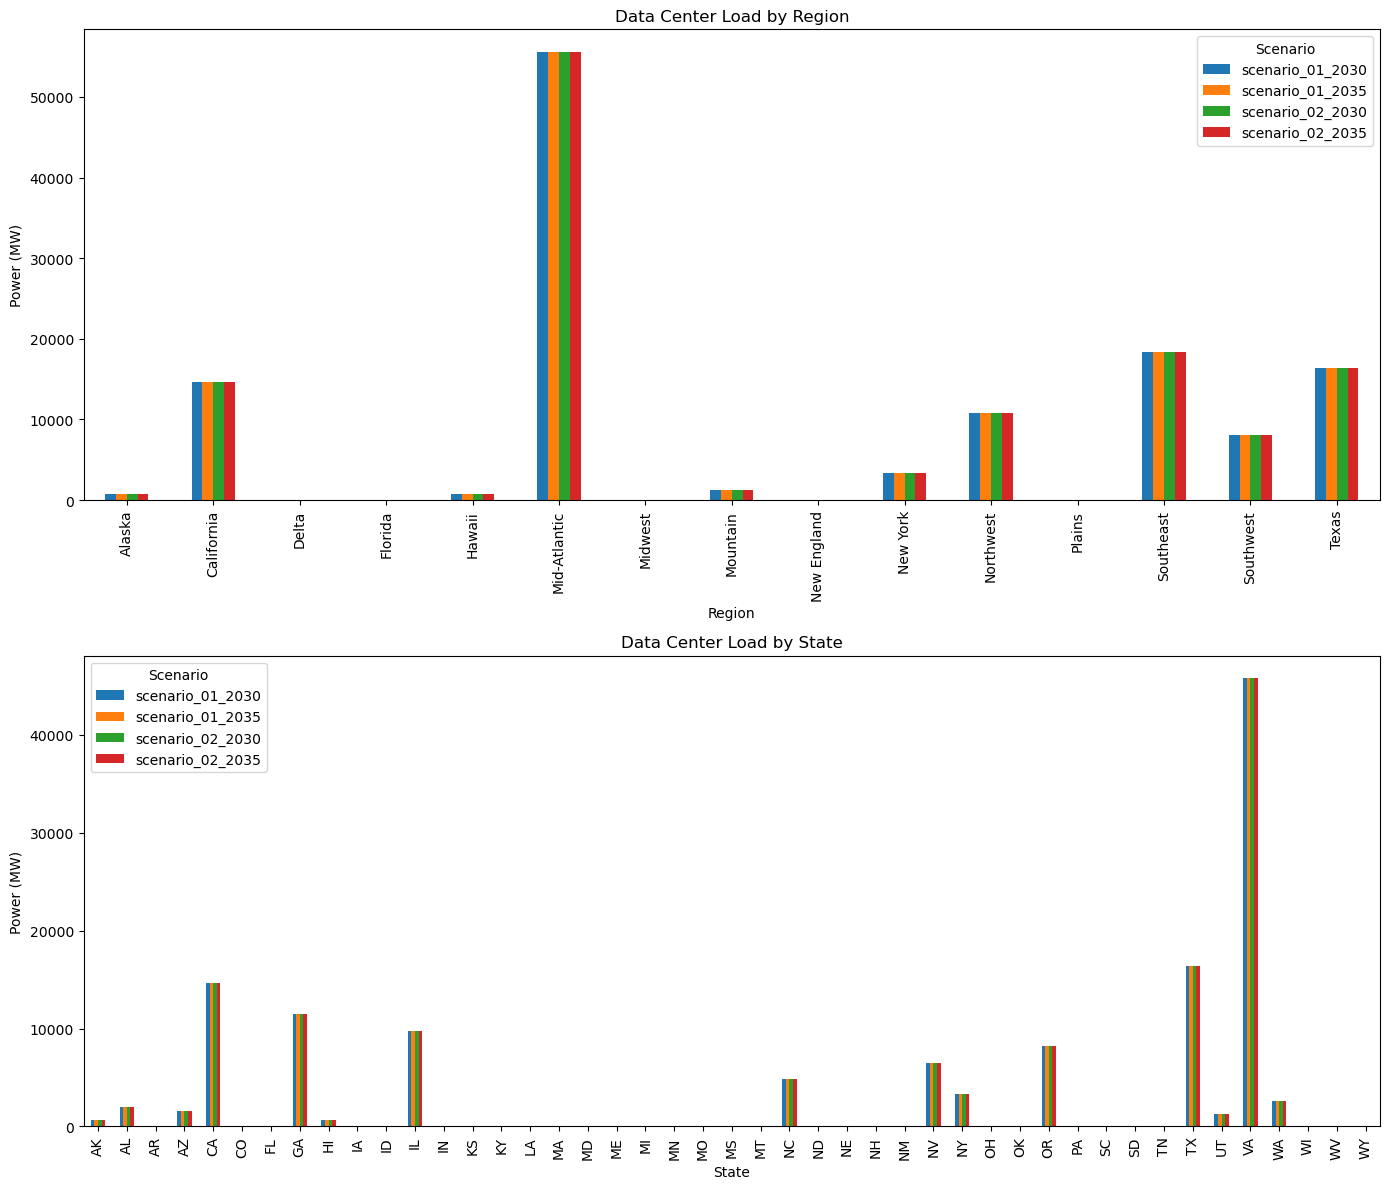

In [ ]:
# fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=False)

# # Plot by region
# data_center_df_region.plot(kind='bar', stacked=False, ax=axes[0],)
# axes[0].set_title("Data Center Load by Region")
# axes[0].set_ylabel("Power (MW)")
# axes[0].set_xlabel("Region")
# axes[0].legend(title="Scenario")

# # Plot by state
# data_center_df_state.plot(kind='bar', stacked=False, ax=axes[1])
# axes[1].set_title("Data Center Load by State")
# axes[1].set_ylabel("Power (MW)")
# axes[1].set_xlabel("State")
# axes[1].legend(title="Scenario")

# plt.tight_layout()
# plt.show()

---

## 3. High-Level Results: System Cost

*This section presents the primary objective function result: the total annualized system cost.*

### 3.1. Total System Cost per Scenario
*A comparison of the total system cost across all analyzed scenarios. This is the key metric for overall economic performance.*

In [ ]:

# RENAME_TECHNOLOGIES = {
#     # --- Electricity Generation ---
#     'Onshore Wind': 'onshore wind',
#     'Offshore Wind (AC)': 'offshore wind',
#     'Offshore Wind (DC)': 'offshore wind',
#     'Solar': 'solar',
#     'solar rooftop': 'solar',
#     'Csp': 'solar',
#     'Run of River': 'hydro',
#     'Reservoir & Dam': 'hydro',
#     'Geothermal': 'geothermal',
#     'Nuclear': 'nuclear',
#     'CCGT': 'gas power',
#     'OCGT': 'gas power',
#     'urban central gas CHP': 'gas power',
#     'H2 Fuel Cell': 'hydrogen power',
#     'coal': 'coal power',
#     'lignite': 'coal power',
#     'biomass': 'biomass power',
#     'biomass EOP': 'biomass power',
#     'urban central solid biomass CHP': 'biomass power',
#     'oil': 'oil power',

#     # --- Hydrogen & P2X ---
#     'Alkaline electrolyzer large': 'hydrogen production',
#     'PEM electrolyzer': 'hydrogen production',
#     'SOEC': 'hydrogen production',
#     'SMR': 'hydrogen production',
#     'SMR CC': 'hydrogen production',
#     'Fischer-Tropsch': 'power-to-x',
#     'Haber-Bosch': 'power-to-x',
#     'Sabatier': 'methanation',
#     'helmeth': 'methanation',

#     # --- Energy Storage ---
#     'battery': 'battery storage',
#     'battery storage': 'battery storage',
#     'home battery': 'battery storage',
#     'battery charger': 'battery storage',
#     'battery discharger': 'battery storage',
#     'home battery charger': 'battery storage',
#     'home battery discharger': 'battery storage',
#     'B2B': 'battery storage', # Bus-to-Bus is often a battery
#     'Pumped Hydro Storage': 'hydro storage',
#     'H2 Store Tank': 'hydrogen storage',
#     'residential rural water tanks': 'thermal storage',
#     'residential urban decentral water tanks': 'thermal storage',
#     'services rural water tanks': 'thermal storage',
#     'services urban decentral water tanks': 'thermal storage',
#     'urban central water tanks': 'thermal storage',
#     'residential rural water tanks charger': 'thermal storage',
#     'residential urban decentral water tanks charger': 'thermal storage',
#     'services rural water tanks charger': 'thermal storage',
#     'urban central water tanks charger': 'thermal storage',
#     'residential rural water tanks discharger': 'thermal storage',
#     'residential urban decentral water tanks discharger': 'thermal storage',
#     'services rural water tanks discharger': 'thermal storage',
#     'urban central water tanks discharger': 'thermal storage',
    
#     # --- Heat Technologies ---
#     'residential rural ground heat pump': 'heat pumps',
#     'services rural ground heat pump': 'heat pumps',
#     'residential urban decentral air heat pump': 'heat pumps',
#     'services urban decentral air heat pump': 'heat pumps',
#     'urban central air heat pump': 'heat pumps',
#     'residential rural gas boiler': 'gas boilers',
#     'residential urban decentral gas boiler': 'gas boilers',
#     'services rural gas boiler': 'gas boilers',
#     'urban central gas boiler': 'gas boilers',
#     'residential rural resistive heater': 'resistive heaters',
#     'residential urban decentral resistive heater': 'resistive heaters',
#     'services rural resistive heater': 'resistive heaters',
#     'urban central resistive heater': 'resistive heaters',
#     'residential rural solar thermal': 'solar thermal',
#     'residential urban decentral solar thermal': 'solar thermal',
#     'services rural solar thermal': 'solar thermal',
#     'services urban decentral solar thermal': 'solar thermal',
#     'urban central solar thermal': 'solar thermal',

#     # --- Infrastructure ---
#     'AC': 'grid infrastructure',
#     'DC': 'grid infrastructure',
#     'electricity distribution grid': 'grid infrastructure',
#     'H2 pipeline': 'hydrogen infrastructure',
#     'H2 pipeline repurposed': 'hydrogen infrastructure',
#     'CO2 pipeline': 'co2 infrastructure',
#     'solid biomass transport': 'biomass infrastructure',

#     # --- Industrial Processes & Feedstocks ---
#     'BF-BOF': 'steel production',
#     'BF-BOF CC': 'steel production',
#     'DRI': 'steel production',
#     'DRI CC': 'steel production',
#     'EAF': 'steel production',
#     'dry clinker': 'cement production',
#     'dry clinker CC': 'cement production',
#     'cement finishing': 'cement production',
#     'ethanol from starch': 'biofuel production',
#     'ethanol from starch CC': 'biofuel production',
#     'biogas to gas': 'biogas upgrading',
#     'iron ore': 'industrial feedstock',
#     'scrap steel': 'industrial feedstock',
#     'solid biomass for industry': 'industrial feedstock',
#     'gas for industry': 'industrial feedstock',

#     # --- CO2 Management ---
#     'DAC': 'co2 capture',
#     'co2 stored': 'co2 storage',
#     'co2 vent': 'co2 emissions',
#     'process emissions': 'co2 emissions',
#     'gas emissions': 'co2 emissions',
#     'oil emissions': 'co2 emissions',
#     'industry coal emissions': 'co2 emissions',
#     'land transport oil emissions': 'co2 emissions',
#     'shipping oil emissions': 'co2 emissions',
    
#     # --- Demand / Loads (Simplified) ---
#     'agriculture electricity': 'electricity demand',
#     'industry electricity': 'electricity demand',
#     'services electricity': 'electricity demand',
#     'other electricity': 'electricity demand',
#     'data center': 'electricity demand',
#     'rail transport electricity': 'electricity demand',
#     'land transport EV': 'electricity demand',
#     'BEV charger': 'electricity demand',
#     'V2G': 'electricity demand',
#     'residential rural heat': 'heat demand',
#     'residential urban decentral heat': 'heat demand',
#     'services rural heat': 'heat demand',
#     'services urban decentral heat': 'heat demand',
#     'urban central heat': 'heat demand',
#     'low-temperature heat for industry': 'heat demand',
#     'kerosene for aviation': 'transport fuel demand',
#     'e-kerosene for aviation': 'transport fuel demand',
#     'land transport oil': 'transport fuel demand',
#     'shipping oil': 'transport fuel demand',
#     'rail transport oil': 'transport fuel demand',
#     'H2 for industry': 'hydrogen demand',
#     'H2 for shipping': 'hydrogen demand',
#     'grid H2': 'hydrogen demand',

#     # --- Raw Commodities & Fuels (as carriers) ---
#     'H2': 'hydrogen',
#     'gas': 'natural gas',
#     'biogas': 'biogas',
#     'NH3': 'ammonia',
#     'e-kerosene': 'e-kerosene',
#     'ethanol': 'ethanol',
#     'bioethanol crop': 'biomass',
#     'naphtha for industry': 'oil products',
#     'co2': 'co2',
    
#     # --- Storage of Commodities ---
#     'bioethanol crop store': 'biomass storage',
#     'biomass storage': 'biomass storage',
#     'clinker store': 'commodity storage',
#     'iron ore store': 'commodity storage',
#     'scrap steel store': 'commodity storage'
# }

In [ ]:
rename_dict = {
    'Csp': 'solar',
    'Geothermal': 'geothermal',
    'Nuclear': 'nuclear',
    'Offshore Wind (AC)': 'wind',
    'Offshore Wind (DC)': 'wind',
    'Onshore Wind': 'wind',
    'Run of River': 'hydro',
    'Solar': 'solar',
    'bioethanol crop': 'Biofuels',
    'biomass': 'biomass',
    'coal': 'coal',
    'gas': 'Fossil Fuels',
    'iron ore': 'Industry',
    'lignite': 'Fossil Fuels',
    'oil': 'oil',
    'residential rural solar thermal': 'Heating',
    'residential urban decentral solar thermal': 'Heating',
    'scrap steel': 'Industry',
    'services rural solar thermal': 'Heating',
    'services urban decentral solar thermal': 'Heating',
    'solar rooftop': 'solar',
    'urban central solar thermal': 'Heating',
    'AC': 'Infrastructure',
    'Alkaline electrolyzer large': 'Hydrogen & Electrolyzers',
    'B2B': 'Others',
    'BEV charger': 'Transport',
    'BF-BOF': 'Industry',
    'BF-BOF CC': 'Industry',
    'CCGT': 'gas',
    'CO2 pipeline': 'Infrastructure',
    'DAC': 'Industry',
    'DC': 'Infrastructure',
    'DRI': 'Industry',
    'DRI CC': 'Industry',
    'EAF': 'Industry',
    'Fischer-Tropsch': 'Industry',
    'H2': 'Hydrogen & Electrolyzers',
    'H2 Fuel Cell': 'Hydrogen & Electrolyzers',
    'H2 pipeline': 'Hydrogen & Electrolyzers',
    'H2 pipeline repurposed': 'Hydrogen & Electrolyzers',
    'Haber-Bosch': 'Hydrogen & Electrolyzers',
    'OCGT': 'gas',
    'PEM electrolyzer': 'Hydrogen & Electrolyzers',
    'SMR': 'Hydrogen & Electrolyzers',
    'SMR CC': 'Hydrogen & Electrolyzers',
    'SOEC': 'Hydrogen & Electrolyzers',
    'Sabatier': 'Hydrogen & Electrolyzers',
    'V2G': 'Transport',
    'battery charger': 'Transport',
    'battery discharger': 'Transport',
    'biogas to gas': 'Fossil Fuels',
    'biomass EOP': 'Industry',
    'cement finishing': 'Industry',
    'co2 vent': 'Emissions',
    'dry clinker': 'Industry',
    'dry clinker CC': 'Industry',
    'e-kerosene-to-main': 'Transport',
    'e-kerosene-to-oil': 'Transport',
    'electricity distribution grid': 'Infrastructure',
    'ethanol from starch': 'Industry',
    'ethanol from starch CC': 'Industry',
    'gas for industry': 'Fossil Fuels',
    'grid H2': 'Hydrogen & Electrolyzers',
    'helmeth': 'Hydrogen & Electrolyzers',
    'home battery charger': 'Transport',
    'home battery discharger': 'Transport',
    'main-to-e-kerosene': 'Transport',
    'process emissions': 'Emissions',
    'residential rural gas boiler': 'Heating',
    'residential rural ground heat pump': 'Heating',
    'residential rural resistive heater': 'Heating',
    'residential rural water tanks charger': 'Heating',
    'residential rural water tanks discharger': 'Heating',
    'residential urban decentral air heat pump': 'Heating',
    'residential urban decentral gas boiler': 'Heating',
    'residential urban decentral resistive heater': 'Heating',
    'residential urban decentral water tanks charger': 'Heating',
    'residential urban decentral water tanks discharger': 'Heating',
    'services rural gas boiler': 'Heating',
    'services rural ground heat pump': 'Heating',
    'services rural resistive heater': 'Heating',
    'services rural water tanks charger': 'Heating',
    'services rural water tanks discharger': 'Heating',
    'services urban decentral air heat pump': 'Heating',
    'services urban decentral gas boiler': 'Heating',
    'services urban decentral resistive heater': 'Heating',
    'services urban decentral water tanks charger': 'Heating',
    'services urban decentral water tanks discharger': 'Heating',
    'solid biomass for industry': 'Industry',
    'solid biomass transport': 'Transport',
    'urban central air heat pump': 'Heating',
    'urban central gas CHP': 'Infrastructure',
    'urban central gas boiler': 'Heating',
    'urban central resistive heater': 'Heating',
    'urban central solid biomass CHP': 'Heating',
    'urban central water tanks charger': 'Heating',
    'urban central water tanks discharger': 'Heating',
    'DRI': 'Industry',
    'H2 for industry': 'Hydrogen & Electrolyzers',
    'H2 for shipping': 'Hydrogen & Electrolyzers',
    'NH3': 'Others',
    'agriculture electricity': 'Others',
    'agriculture oil': 'Fossil Fuels',
    'cement': 'Industry',
    'data center': 'Infrastructure',
    'e-kerosene for aviation': 'Transport',
    'ethanol': 'Industry',
    'gas emissions': 'Emissions',
    'industry coal emissions': 'Emissions',
    'industry electricity': 'Others',
    'industry oil emissions': 'Emissions',
    'kerosene for aviation': 'Transport',
    'land transport EV': 'Transport',
    'land transport oil': 'Fossil Fuels',
    'land transport oil emissions': 'Emissions',
    'low-temperature heat for industry': 'Industry',
    'naphtha for industry': 'Fossil Fuels',
    'oil emissions': 'Emissions',
    'other electricity': 'Others',
    'rail transport electricity': 'Transport',
    'rail transport oil': 'Fossil Fuels',
    'residential biomass': 'biomass',
    'residential gas': 'Fossil Fuels',
    'residential oil': 'Fossil Fuels',
    'residential rural heat': 'Others',
    'residential urban decentral heat': 'Others',
    'services biomass': 'biomass',
    'services electricity': 'Others',
    'services gas': 'Fossil Fuels',
    'services oil': 'Fossil Fuels',
    'services rural heat': 'Others',
    'services urban decentral heat': 'Others',
    'shipping oil': 'Fossil Fuels',
    'shipping oil emissions': 'Emissions',
    'steel BF-BOF': 'Industry',
    'steel EAF': 'Industry',
    'urban central heat': 'Heating',
    'Pumped Hydro Storage': 'hydro',
    'Reservoir & Dam': 'hydro',
    'H2 Store Tank': 'Storage',
    'battery': 'Storage',
    'battery storage': 'Storage',
    'bioethanol crop store': 'Storage',
    'biogas': 'biomass',
    'clinker store': 'Storage',
    'co2': 'Emissions',
    'co2 stored': 'Storage',
    'e-kerosene': 'Transport',
    'home battery': 'Storage',
    'iron ore store': 'Storage',
    'residential rural water tanks': 'Heating',
    'residential urban decentral water tanks': 'Heating',
    'scrap steel store': 'Storage',
    'services rural water tanks': 'Heating',
    'services urban decentral water tanks': 'Heating',
    'urban central water tanks': 'Heating',
    'solid biomass': 'biomass',
}

carrier_colors = {
    'Biofuels': '#66c2a5',              # soft green-blue
    'Emissions': '#7f7f7f',             # neutral gray
    'Fossil Fuels': '#8c564b',          # earthy brown
    'Heating': '#d62728',               # red-hot
    'Hydrogen & Electrolyzers': '#1f77b4',  # hydrogen blue
    'Industry': '#9467bd',              # purple
    'Infrastructure': '#bcbd22',        # olive green
    'Others': '#c7c7c7',                # light gray
    'Storage': '#17becf',               # teal
    'Transport': '#ff7f0e',             # orange
    'biomass': '#2ca02c',               # green
    'coal': '#4d4d4d',                  # dark gray/black
    'gas': '#1f77b4',                   # blue (same as hydrogen for now)
    'geothermal': '#aca64b',            # brownish (same as fossil, can be changed)
    'hydro': '#1f78b4',                 # deep water blue
    'nuclear': '#e377c2',               # pinkish purple
    'oil': '#7f3b08',                   # dark brown
    'solar': '#ffdd57',                 # bright yellow
    'wind': '#a6cee3'                   # light sky blue
}

In [ ]:
# def compute_carrier_costs(network):
#     """Compute total carrier costs by region and by state
#     """
#     cost_df = network.statistics()[['Capital Expenditure', "Operational Expenditure"]]
#     carrier_cost_df = cost_df.reset_index(level=0, drop=True).sum(axis=1).reset_index().rename(columns={0:'cost'})
#     carrier_cost_df.carrier = carrier_cost_df.carrier.map(plotting['rename_tech'])
#     grouped_carrier_cost_df = carrier_cost_df.groupby(['carrier'])[['cost']].sum()

#     return grouped_carrier_cost_df

In [ ]:
# networks.keys()

dict_keys(['scenario_01_2030', 'scenario_01_2035', 'scenario_02_2030', 'scenario_02_2035'])

In [ ]:
# for idx, network in enumerate(networks.keys()):
#     carrier_costs = compute_carrier_costs(networks[network]).rename(columns={"cost": network_names[idx]}) / 1e9
#     if idx == 0:
#         total_carrier_costs = carrier_costs
#     else:
#         total_carrier_costs = total_carrier_costs.join(carrier_costs, how='outer', rsuffix=f'_{idx}')

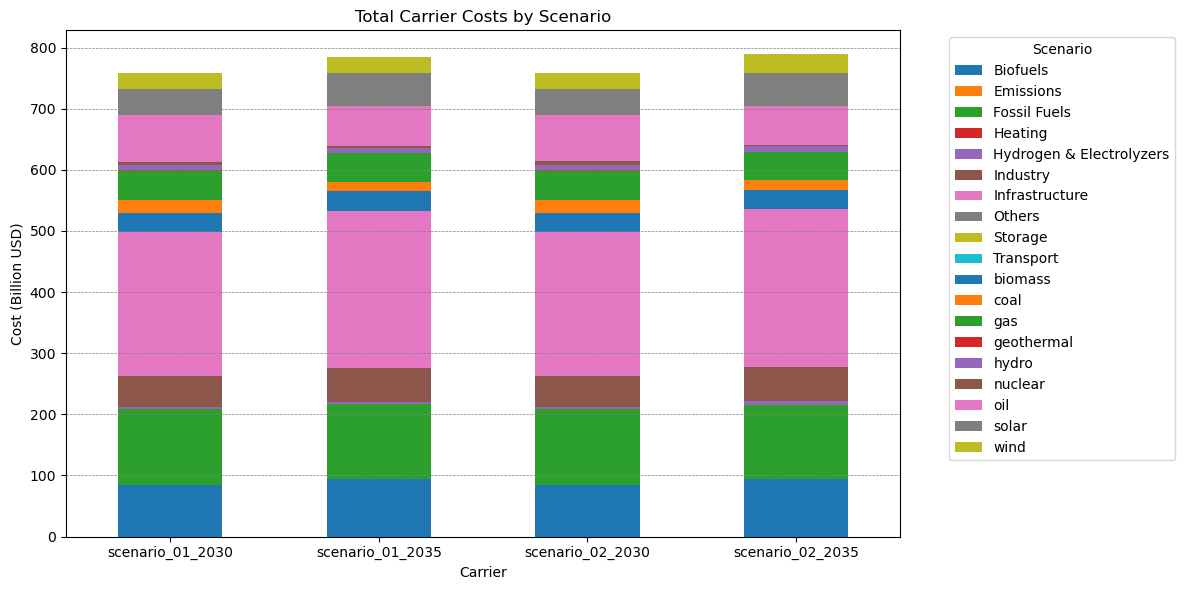

In [ ]:
# total_carrier_costs.T.plot(kind='bar', stacked=True, figsize=(12, 6))
# plt.title("Total Carrier Costs by Scenario")
# plt.ylabel("Cost (Billion USD)")
# plt.xlabel("Scenarios")
# plt.xticks(rotation=0)
# plt.grid(axis='y', linestyle='--', linewidth=0.5, color='gray')
# plt.legend(title="Carriers", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()

In [ ]:
compute_carrier_costs(networks['scenario_01_2030'])

---

## 4. Capacity Analysis: What Was Built?

*Here, we analyze the optimal installed capacities of generation, storage, and conversion technologies as determined by the model.*

### 4.1. Map: Total Installed Electricity Capacity
*A map showing the total installed capacity (in GW) for each electricity generation carrier (e.g., Solar, Onshore Wind, Offshore Wind) at different locations.*

In [9]:
def update_ac_dc_bus_coordinates(network):
    """
    For all buses with carrier 'AC' or 'DC', update their 'x' and 'y' coordinates
    based on their 'location' field and the mapping from existing AC/DC buses.
    """
    ac_dc_carriers = ["AC", "DC"]
    location_mapping = network.buses.query("carrier in @ac_dc_carriers")[["x", "y"]]
    network.buses["x"] = network.buses["location"].map(location_mapping["x"]).fillna(0)
    network.buses["y"] = network.buses["location"].map(location_mapping["y"]).fillna(0)
    return network

def fill_missing_nice_names(n, nice_names):
    """
    Fill missing nice_name values in n.carriers using the provided nice_names dict.
    Prints carriers that were missing and their new nice_name.
    """
    missing = n.carriers[n.carriers.nice_name == ""].index
    for idx in missing:
        # print(f"Carrier '{idx}' is missing from the network.")
        if idx in nice_names:
            n.carriers.nice_name[idx] = nice_names[idx]
            # print(n.carriers.nice_name[idx])
        else:
            print(f"No nice_name found for '{idx}' in nice_names dictionary.")

def fill_missing_color(n, color):
    """
    Fill missing color values in n.carriers using the provided color dict.
    Prints carriers that were missing and their new color.
    """
    missing = n.carriers[n.carriers.color == ""].index
    for idx in missing:
        # print(f"Carrier '{idx}' is missing from the network.")
        if idx in color:
            n.carriers.color[idx] = color[idx]
            # print(n.carriers.color[idx])
        else:
            print(f"No color found for '{idx}' in color dictionary.")

In [10]:
fill_missing_color(n, plotting['tech_colors'])
fill_missing_nice_names(n, plotting['nice_names'])

NameError: name 'n' is not defined

In [ ]:
# n = networks['scenario_01_2030'].copy()

In [ ]:
# # [onwind, offwind-ac, offwind-dc, solar, solar-rooftop, csp, nuclear, geothermal, ror, PHS, Reservior & Dam]
# conventional_gen_carriers = [
#     'OCGT', 'CCGT', 'oil', 'coal', 'lignite',
#     'biomass', 'urban central gas CHP', 'urban central gas CHP CC', 'biomass EOP',
#     'urban central solid biomass CHP',
#     'urban central solid biomass CHP CC'
# ]

In [ ]:
# n.links.query("carrier in @conventional_gen_carriers", inplace=True)

In [ ]:
# res_carriers = [
#     "solar", "onwind", "offwind-ac", "offwind-dc", "ror", 
#     "hydro", "geothermal", "nuclear", "csp", "solar-rooftop", 
#     "PHS", "Reservoir & Dam"]


In [ ]:
# n.buses.query("carrier in @res_carriers", inplace=True)

In [ ]:
n.buses_t.p

In [ ]:
# n.links.carrier.unique()

array(['OCGT', 'CCGT', 'biomass', 'lignite', 'urban central gas CHP',
       'biomass EOP', 'urban central solid biomass CHP', 'coal', 'oil'],
      dtype=object)

In [ ]:
# gen_carriers = ['csp', 'onwind', 'solar', 'nuclear', 'offwind-ac', 'offwind-dc',
#        'geothermal', 'gas', 'oil', 'coal', 'biomass', 'lignite', 'ror', 'solar rooftop']

In [ ]:
# n.generators.query("carrier in @gen_carriers", inplace=True)

In [ ]:
# n.storage_units.carrier.unique()

array(['PHS', 'hydro'], dtype=object)

In [ ]:
# n = update_ac_dc_bus_coordinates(n)

In [ ]:
# n.buses

In [ ]:
# costs_rigid = n.statistics()[["Capital Expenditure", "Operational Expenditure"]].dropna()
# full_costs_rigid = costs_rigid.sum(axis=1).droplevel(0).to_frame()
# full_costs_rigid.columns = ["rigid"]

# costs_flex = n.statistics()[["Capital Expenditure", "Operational Expenditure"]].dropna()
# full_costs_flex = costs_flex.sum(axis=1).droplevel(0).to_frame()
# full_costs_flex.columns = ["flexible"]

# costs_igas_tes = n.statistics()[["Capital Expenditure", "Operational Expenditure"]].dropna()
# full_costs_igas_tes = costs_igas_tes.sum(axis=1).droplevel(0).to_frame()
# full_costs_igas_tes.columns = ["igas+tes"]

In [ ]:
# cost_df = full_costs_flex.join(full_costs_igas_tes, how="outer").join(full_costs_rigid, how="outer").fillna(0)
# cost_df

In [ ]:
# plotting["tech_colors"]

In [ ]:
# renaming function
def rename_techs(label):
    prefix_to_remove = [
        "residential ",
        "services ",
        "urban ",
        "rural ",
        "central ",
        "decentral ",
    ]

    rename_if_contains = [
        "solid biomass CHP",
        "gas CHP",
        "gas boiler",
        "biogas",
        "solar thermal",
        "air heat pump",
        "ground heat pump",
        "resistive heater",
        "Fischer-Tropsch",
    ]

    rename_if_contains_dict = {
        "water tanks": "TES",
        "retrofitting": "building retrofitting",
        # "H2 Electrolysis": "hydrogen storage",
        # "H2 Fuel Cell": "hydrogen storage",
        # "H2 pipeline": "hydrogen storage",
        "battery": "battery storage",
        # "CC": "CC"
    }

    rename = {
        "Solar": "solar PV",
        "solar": "solar PV",
        "Sabatier": "methanation",
        "helmeth" : "methanation",
        "Offshore Wind (AC)": "offshore wind",
        "Offshore Wind (DC)": "offshore wind",
        "Onshore Wind": "onshore wind",
        "offwind-ac": "offshore wind",  
        "offwind-dc": "offshore wind",
        "Run of River": "hydroelectricity",
        "Run of river": "hydroelectricity",
        "Reservoir & Dam": "hydroelectricity",
        "Pumped Hydro Storage": "hydroelectricity",
        "PHS": "hydroelectricity",
        "NH3": "ammonia",
        "co2 Store": "DAC",
        "co2 stored": "CO2 sequestration",
        "AC": "transmission lines",
        "DC": "transmission lines",
        "B2B": "transmission lines",
        "solid biomass for industry": "solid biomass",
        "solid biomass for industry CC": "solid biomass",
        "electricity distribution grid": "distribution lines",
        "Open-Cycle Gas":"OCGT",
        "gas": "gas storage",
        'gas pipeline new': 'gas pipeline',
        "gas for industry CC": "gas for industry",
        "SMR CC": "SMR",
        "process emissions CC": "process emissions",
        "Battery Storage": "battery storage",
        'H2 Store': "H2 storage",
        'Hydrogen Storage': "H2 storage",
        'co2 sequestered': "CO2 sequestration",
        
    }

    for ptr in prefix_to_remove:
        if label[: len(ptr)] == ptr:
            label = label[len(ptr) :]

    for rif in rename_if_contains:
        if rif in label:
            label = rif

    for old, new in rename_if_contains_dict.items():
        if old in label:
            label = new

    for old, new in rename.items():
        if old == label:
            label = new
    return label


preferred_order = pd.Index(
    [
        "solid biomass",
        "biogas",
        "gas for industry",
        "methanol",
        "oil",
        
        "transmission lines",
        "distribution lines",
        "gas pipeline",
        "H2 pipeline",
        
        "H2 Electrolysis",
        "H2 Fuel Cell",
        "DAC",
        "Fischer-Tropsch",
        "methanation",
        "BEV charger",
        "V2G",
        "SMR",
        "methanolisation",
        
        "battery storage",
        "gas storage",
        "H2 storage",
        "TES",
        
        "hydroelectricity",
        "OCGT",
        "onshore wind",
        "offshore wind",
        "solar PV",
        "solar thermal",
        "solar rooftop",

        "gas CHP",
        "solid biomass CHP",
        "resistive heater",
        "air heat pump",
        "ground heat pump",
        "gas boiler",
        "biomass boiler",
        "building retrofitting",
        
        "co2",
        "CO2 sequestration",
        "process emissions"
     ]
)

In [ ]:
# renaming function
def rename_techs2(label):
    prefix_to_remove = [
        "residential ",
        "services ",
        "urban ",
        "rural ",
        "central ",
        "decentral ",
    ]

    rename_if_contains = [
        "solid biomass CHP",
        "gas CHP",
        "gas boiler",
        "biogas",
        "solar thermal",
        "air heat pump",
        "ground heat pump",
        "resistive heater",
        "Fischer-Tropsch",
    ]

    rename_if_contains_dict = {
        "water tanks": "water tanks discharger",
        "retrofitting": "building retrofitting",
        # "H2 Electrolysis": "hydrogen storage",
        # "H2 Fuel Cell": "hydrogen storage",
        # "H2 pipeline": "hydrogen storage",
        "battery": "battery storage",
        # "CC": "CC"
    }

    rename = {
        "Solar": "solar PV",
        "solar": "solar PV",
        "Sabatier": "methanation",
        "helmeth" : "methanation",
        "Offshore Wind (AC)": "offshore wind",
        "Offshore Wind (DC)": "offshore wind",
        "Onshore Wind": "onshore wind",
        "offwind-ac": "offshore wind",  
        "offwind-dc": "offshore wind",
        "Run of River": "hydroelectricity",
        "Run of river": "hydroelectricity",
        "Reservoir & Dam": "hydroelectricity",
        "Pumped Hydro Storage": "hydroelectricity",
        "PHS": "hydroelectricity",
        "NH3": "ammonia",
        "co2 Store": "DAC",
        "co2 stored": "CO2 sequestration",
        "AC": "transmission lines",
        "DC": "transmission lines",
        "B2B": "transmission lines",
        "solid biomass for industry": "solid biomass",
        "solid biomass for industry CC": "solid biomass",
        "electricity distribution grid": "distribution lines",
        "Open-Cycle Gas":"OCGT",
        "gas": "gas storage",
        'gas pipeline new': 'gas pipeline',
        "gas for industry CC": "gas for industry",
        "SMR CC": "SMR",
        "process emissions CC": "process emissions",
        "Battery Storage": "battery storage",
        'H2 Store': "H2 storage",
        'Hydrogen Storage': "H2 storage",
        'co2 sequestered': "CO2 sequestration",
        
    }

    for ptr in prefix_to_remove:
        if label[: len(ptr)] == ptr:
            label = label[len(ptr) :]

    for rif in rename_if_contains:
        if rif in label:
            label = rif

    for old, new in rename_if_contains_dict.items():
        if old in label:
            label = new

    for old, new in rename.items():
        if old == label:
            label = new
    return label


preferred_order = pd.Index(
    [
        "solid biomass",
        "biogas",
        "gas for industry",
        "methanol",
        "oil",
        
        "transmission lines",
        "distribution lines",
        "gas pipeline",
        "H2 pipeline",
        
        "H2 Electrolysis",
        "H2 Fuel Cell",
        "DAC",
        "Fischer-Tropsch",
        "methanation",
        "BEV charger",
        "V2G",
        "SMR",
        "methanolisation",
        
        "battery storage",
        "gas storage",
        "H2 storage",
        "water tanks discharger",
        
        "hydroelectricity",
        "OCGT",
        "onshore wind",
        "offshore wind",
        "solar PV",
        "solar thermal",
        "solar rooftop",
        
        "building retrofitting",
        "solid biomass CHP",
        "gas CHP",
        "biomass boiler",
        "gas boiler",
        "resistive heater",
        "air heat pump",
        "ground heat pump",
        
        "co2",
        "CO2 sequestration",
        "process emissions"
     ]
)

In [ ]:
def plot_costs(cost_df):
    df = cost_df.groupby(cost_df.index).sum()

    # convert to billions
    df = df / 1e9
    df = df.groupby(df.index.map(rename_techs)).sum()

    costs_threshold = 0.5
    to_drop = df.index[df.max(axis=1) < costs_threshold]  #df <

    # logger.info(
    #     f"Dropping technology with costs below {costs_threshold} EUR billion per year"
    # )
    # logger.debug(df.loc[to_drop])

    df = df.drop(to_drop)

    # logger.info(f"Total system cost of {round(df.sum())} EUR billion per year")

    new_index = preferred_order.intersection(df.index).append(
        df.index.difference(preferred_order)
    )

    new_columns = df.sum().sort_values().index  


    fig, ax = plt.subplots(figsize=(6, 8))

    df.loc[new_index].T.plot(
        kind="bar",
        ax=ax,
        stacked=True,
        # color=[plotting["tech_colors"][i] for i in new_index],
    )

    handles, labels = ax.get_legend_handles_labels()

    handles.reverse()
    labels.reverse()

    costs_max = cost_df.sum().max() / 1e9
    ax.set_ylim([0, costs_max])
    plt.xticks(rotation=0, fontsize=12)

    ax.set_ylabel("System Cost [EUR billion per year]")

    ax.set_xlabel("")

    ax.grid(axis="x")

    ax.legend(
        handles, labels, ncol=1, loc="upper left", bbox_to_anchor=[1, 1], frameon=False
    )
    
    ax.set_facecolor('white')
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.grid(axis='y', linestyle='--', linewidth=0.5, color='gray')
    plt.show()
    
    
plot_costs(cost_df)

In [ ]:
# n.plot()

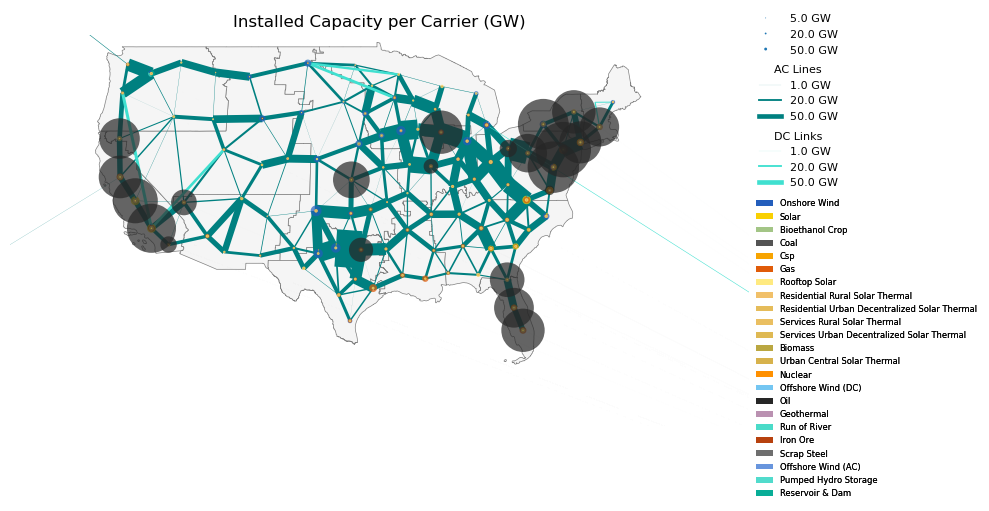

In [ ]:

regions_onshore = gpd.read_file(region_shapes_path)

# --- 2. Prepare Data for Plotting ---
gen_p_nom_opt = n.generators.groupby(["bus", "carrier"]).p_nom_opt.sum()
sto_p_nom_opt = n.storage_units.groupby(["bus", "carrier"]).p_nom_opt.sum()
bus_carrier_capacity = pd.concat([gen_p_nom_opt, sto_p_nom_opt])
bus_carrier_capacity = bus_carrier_capacity[bus_carrier_capacity > 0]

line_values = n.lines.s_nom
links_values = n.links[n.links.carrier == "DC"].p_nom

n = update_ac_dc_bus_coordinates(n)

# Find carriers that need a color
carriers_to_plot = bus_carrier_capacity.index.get_level_values(1).unique()
for carrier in carriers_to_plot:
    if carrier not in n.carriers.index:
        n.add("Carrier", carrier)

# for idx in tech_colors.keys():
#     n.carriers.loc[idx, "color"] = tech_colors[idx]
    
fill_missing_color(n, plotting['tech_colors'])
fill_missing_nice_names(n, plotting['nice_names'])


# --- 3. Plotting Settings ---
bus_scale = 3e5
line_scale = 3e3
bus_sizes_in_legend = [5000, 20000, 50000]
line_sizes_in_legend = [1000, 20000, 50000]

# --- 4. Create the Map Plot ---
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={"projection": ccrs.EqualEarth(central_longitude=-95.66)}
)


bounds = regions_onshore.total_bounds  # returns [minx, miny, maxx, maxy]
boundaries = (bounds[0], bounds[2], bounds[1], bounds[3])

n.plot(
    ax=ax,
    bus_sizes=bus_carrier_capacity / bus_scale,
    bus_alpha=0.7,
    bus_colors=n.carriers.color,
    line_widths=n.lines.s_nom_opt / line_scale,
    link_widths=n.links.p_nom_opt / line_scale,
    line_colors='teal',
    link_colors='Turquoise',
    color_geomap=False,
    flow=None,
    line_cmap='viridis',
    line_norm=None,
    boundaries=[-130, -60, 20, 50], # view showing US mainland
    # boundaries=[-160, -60, 20, 100], #view showing alaska, hawaii, and US mainland,
)


if regions_onshore is not None:
    regions_onshore.plot(
        ax=ax,
        facecolor="whitesmoke",
        edgecolor="gray",
        aspect="equal",
        transform=ccrs.PlateCarree(),
        linewidth=0.5,
    )
    # ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]], crs=ccrs.PlateCarree())

# --- 5. Add Legends ---
legend_kwargs = {"loc": "upper left", "frameon": False, "fontsize": 8}
add_legend_circles(
    ax,
    [s / bus_scale * 0.09 for s in bus_sizes_in_legend],
    [f"{s / 1000} GW" for s in bus_sizes_in_legend],
    legend_kw={
        **legend_kwargs, 
        "bbox_to_anchor": (1, 1.08),},
)
add_legend_lines(
    ax,
    [s / line_scale * 0.2 for s in line_sizes_in_legend],
    [f"{s / 1000} GW" for s in line_sizes_in_legend],
    legend_kw={
        **legend_kwargs, 
        "bbox_to_anchor": (1, 0.95), 
        "title": "AC Lines", 
        "title_fontsize": 8,},
    patch_kw={"color": "teal"},
)
add_legend_lines(
    ax,
    [s / line_scale * 0.2 for s in line_sizes_in_legend],
    [f"{s / 1000} GW" for s in line_sizes_in_legend],
    legend_kw={
        **legend_kwargs,
        "loc": "upper left",
        "bbox_to_anchor": (1, 0.78),
        "title": "DC Links",
        "title_fontsize": 8,
    },
    patch_kw={"color": "Turquoise"} 
)
add_legend_patches(
    ax,
    colors=n.carriers.loc[carriers_to_plot].color,
    labels=n.carriers.loc[carriers_to_plot].nice_name,
    legend_kw={
        **legend_kwargs, 
        "bbox_to_anchor": (1, 0.6), 
        "loc": "upper left", 
        "fontsize": 6},
)

ax.set_title("Installed Capacity per Carrier (GW)", fontsize=12)
fig.tight_layout()
plt.show()

### 4.2. Map: Total Installed Hydrogen Electrolyzer Capacity
*This map visualizes the spatial distribution and total capacity (in GW) of different electrolyzer technologies (e.g., AEL, PEM).*

In [11]:
def assign_location(n):
    for c in n.iterate_components(n.one_port_components | n.branch_components):

        ifind = pd.Series(c.df.index.str.find(" ", start=4), c.df.index)

        for i in ifind.value_counts().index:
            # these have already been assigned defaults
            if i == -1:
                continue

            names = ifind.index[ifind == i]

            c.df.loc[names, 'location'] = names.str[:i]

In [ ]:
# network = networks['scenario_01_2030'].copy()

In [ ]:
h2_carriers_links = ['H2 pipeline repurposed', 'H2 pipeline']
h2_carriers_buses = ['Alkaline electrolyzer large', 'PEM electrolyzer', 'SOEC',]

In [12]:
def plot_h2_capacities_map(network):
    """
    Plot the H2 capacities on a map.
    """
    net = network.copy()
    assign_location(net)

    h2_carriers_links = ['H2 pipeline repurposed', 'H2 pipeline']
    h2_carriers_buses = ['Alkaline electrolyzer large', 'PEM electrolyzer', 'SOEC',]

    hydrogen_links = net.links.query("carrier in @h2_carriers_buses").copy()
    capacity_data = hydrogen_links.merge(
                net.buses[['state']], 
                left_on='bus0',  # Assuming bus0 is the electrical connection
                right_index=True, 
                how='left'
            )
    
    capacity_data['p_nom_kw'] = capacity_data['p_nom_opt'] * 1000
    h2_capacity_data = capacity_data.pivot_table(
        index='bus0',
        columns='carrier',
        values='p_nom_kw',
        fill_value=0
    )

    net.links.query("carrier in @h2_carriers_links", inplace=True)
    valid_buses = net.buses.dropna(subset=["x", "y"])
    valid_buses = valid_buses[
        (valid_buses["x"] > -200) & (valid_buses["x"] < 200) &
        (valid_buses["y"] > -90) & (valid_buses["y"] < 90)
    ]

    fig, ax = plt.subplots(figsize=(14, 10), subplot_kw={"projection": ccrs.PlateCarree()})
    bbox = box(-130, 20, -60, 50)
    regions_onshore_clipped = regions_onshore.to_crs(epsg=4326).clip(bbox)
    regions_onshore_clipped.plot(
            ax=ax,
            facecolor='whitesmoke',
            edgecolor='gray',
            alpha=0.7,
            linewidth=0.5,
            zorder=0,
        )

    line_scale = 5e-3
    net.plot(
            ax=ax,
            bus_sizes=0,
            bus_alpha=0,
            link_widths=net.links.p_nom_opt / line_scale,
            line_colors='teal',
            link_colors='turquoise',
            color_geomap=False,
            flow=None,
            branch_components=['Link'],
            boundaries=[-130, -60, 20, 50],  # view showing
        )
    pie_scale = 1

    for bus_id, capacities in h2_capacity_data.iterrows():
        x, y = valid_buses.loc[bus_id, ['x', 'y']]
        if not bbox.contains(gpd.points_from_xy([x], [y])[0]):
            continue

        values = capacities.values
        total = values.sum()
        if total == 0:
            continue

        size = np.clip(np.sqrt(total) * pie_scale, 0.1, 1.5)
        colors = [tech_colors.get(c, 'gray') for c in capacities.index]
        
        start_angle = 0
        for val, color in zip(values, colors):
            if val == 0:
                continue
            angle = 360 * val / total  # proporzione rispetto al totale del nodo
            wedge = Wedge(
                center=(x, y),
                r=size,
                theta1=start_angle,
                theta2=start_angle + angle,
                facecolor=color,
                edgecolor='k',
                linewidth=0.3,
                transform=ccrs.PlateCarree()._as_mpl_transform(ax),
                zorder=5,
            )
            ax.add_patch(wedge)
            start_angle += angle
            # ax.annotate(f'{total:.02f} kW', 
            #            xy=(x, y - size - 0.3), 
            #            ha='center', va='top', fontsize=5, fontweight='bold')

    class HandlerCircle(HandlerPatch):
        def create_artists(self, legend, orig_handle,
                            xdescent, ydescent, width, height, fontsize, trans):
            center = (width / 2, height / 2)
            radius = orig_handle.get_radius()
            p = plt.Circle(center, radius)
            self.update_prop(p, orig_handle, legend)
            p.set_transform(trans)
            return [p]

    # Legends
    bus_caps = [0.1, 0.5, 1]
    bus_patches = []
    for cap in bus_caps:
        r_in_map = np.sqrt(cap)
        r_pts = r_in_map * fig.dpi * 2
        circ = plt.Circle((0, 0), radius=r_pts / 0.2 / fig.dpi, color='gray', alpha=0.5)
        bus_patches.append(circ)

    bus_legend = ax.legend(
        bus_patches,
        [f"{cap} kW" for cap in bus_caps],
        title="Bus Capacity",
        title_fontsize=10,
        fontsize=10,
        frameon=False,
        handler_map={mpatches.Circle: HandlerCircle()},
        loc='upper right',
        bbox_to_anchor=(1.05, 0.75),
        labelspacing=0.9,
    )


    carrier_handles = [
            mpatches.Patch(color=tech_colors.get(c, 'gray'), label=nice_names.get(c, c))
            for c in sorted(h2_capacity_data.columns) if h2_capacity_data[c].sum() > 0
        ]
    carrier_legend = ax.legend(
        handles=carrier_handles,
        title="Carriers",
        title_fontsize=10,
        fontsize=10,
        frameon=False,
        loc='upper right',
        bbox_to_anchor=(1.05, 0.55),
        ncol=1,
        labelspacing=0.9,
    )

    ax.add_artist(bus_legend)
    ax.add_artist(carrier_legend)

    ax.set_extent([-130, -60, 20, 50], crs=ccrs.PlateCarree())
    ax.autoscale(False)

    ax.set_title('Installed Hydrogen Electrolyzer Capacity', 
                fontsize=12, fontweight='bold', pad=30)
        
    plt.tight_layout()
    plt.show()

    return fig, ax, h2_capacity_data

In [14]:
networks.keys()

dict_keys(['scenario_01_2030', 'scenario_02_2030', 'scenario_06_2030', 'scenario_10_2030'])

Plotting H2 capacities for scenario_01_2030...


NameError: name 'regions_onshore' is not defined

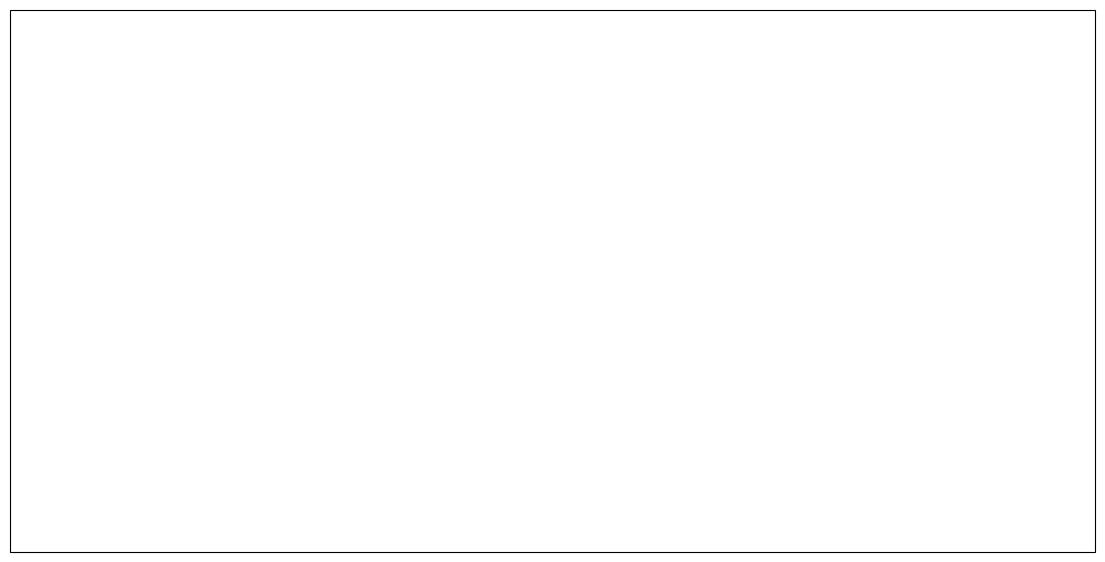

In [15]:
for idx, network in enumerate(networks.keys()):
    print(f"Plotting H2 capacities for {network}...")
    h2_capacity_data = plot_h2_capacities_map(networks[network])

# plot_h2_capacities_map(networks['scenario_01_2030'])

In [ ]:
hydrogen_links = network.links.query("carrier in @h2_carriers_buses").copy()
capacity_data = hydrogen_links.merge(
                network.buses[['state']], 
                left_on='bus0',  # Assuming bus0 is the electrical connection
                right_index=True, 
                how='left'
            )
capacity_data['p_nom_kw'] = capacity_data['p_nom_opt'] * 1000

h2_capacity_data = capacity_data.pivot_table(
    index='bus0',
    columns='carrier',
    values='p_nom_kw',
    fill_value=0
)

In [ ]:
network.links.query("carrier in @h2_carriers_links", inplace=True)

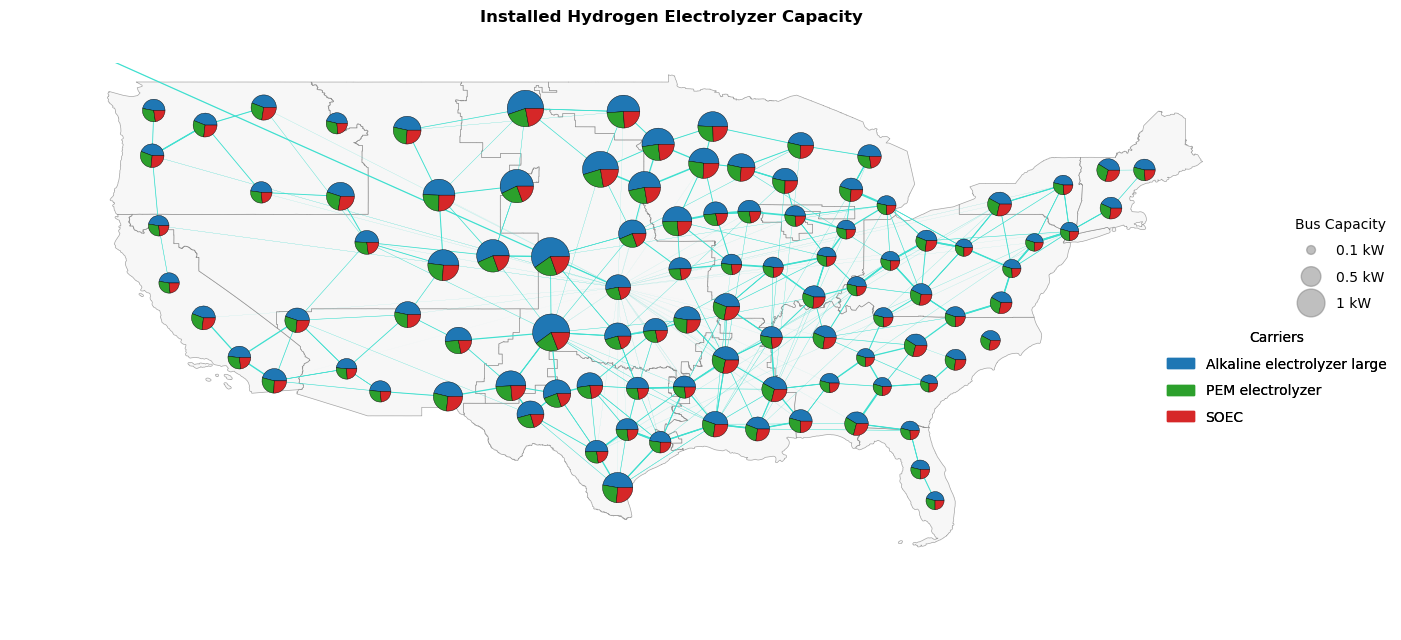

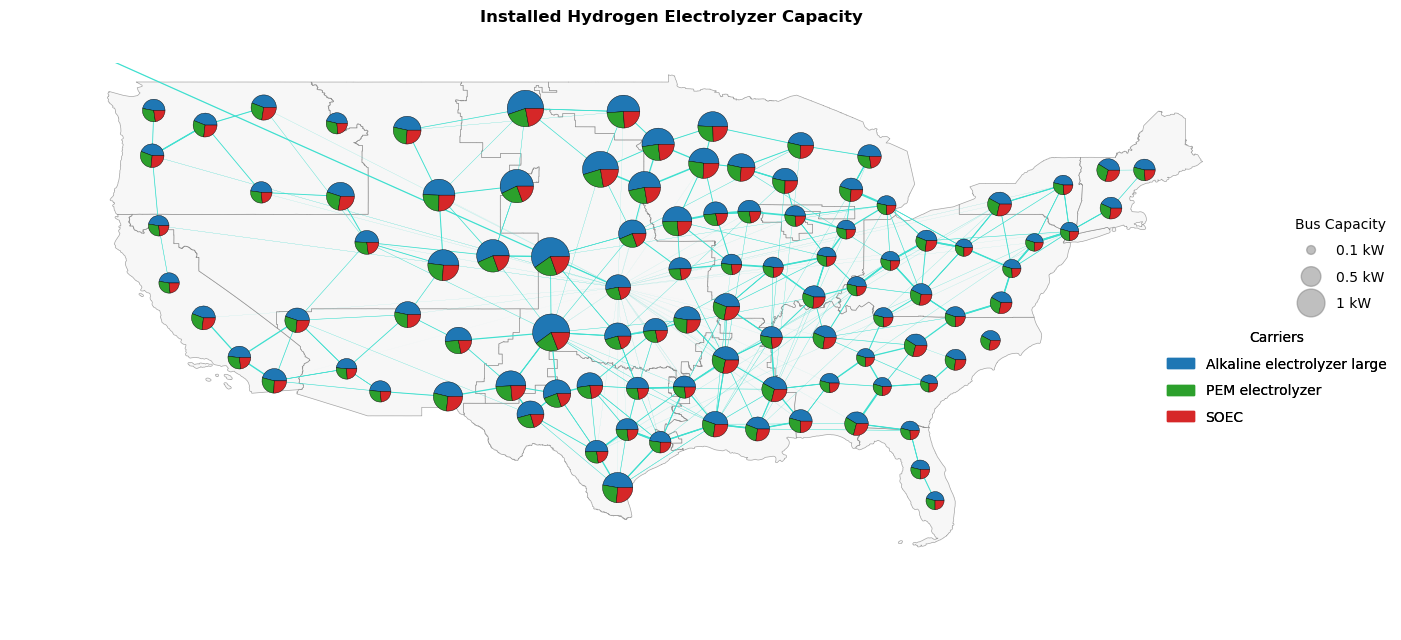

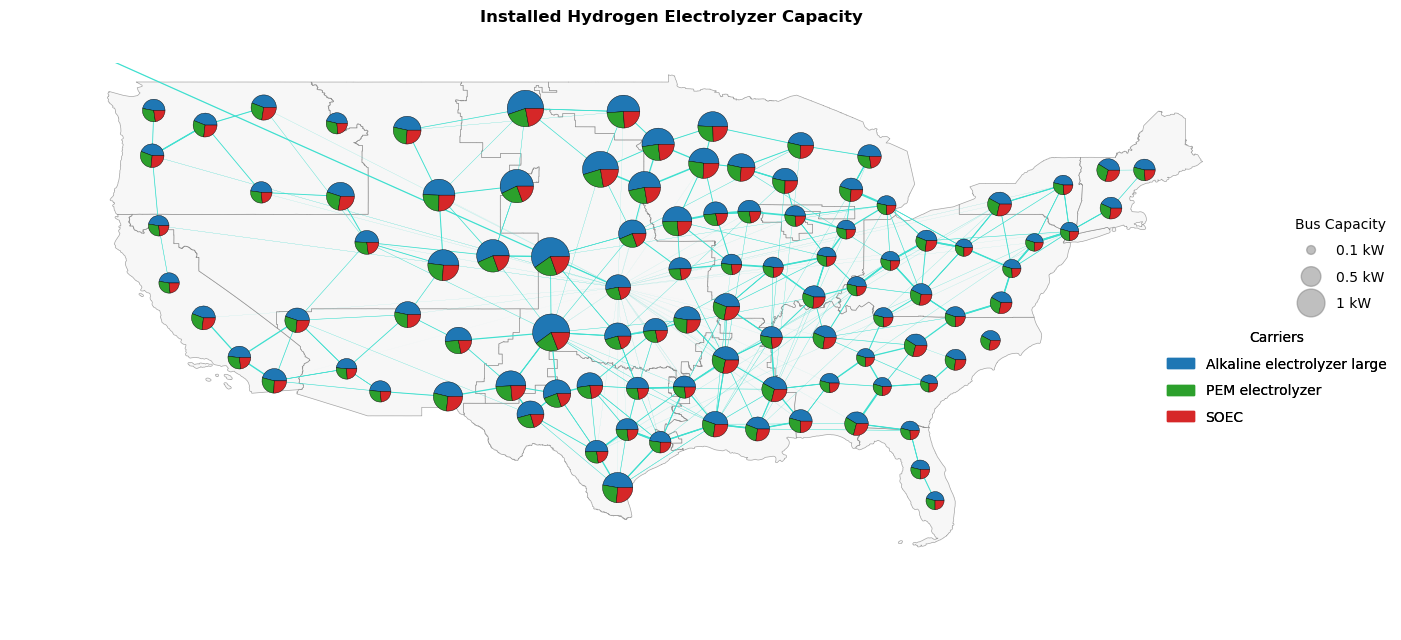

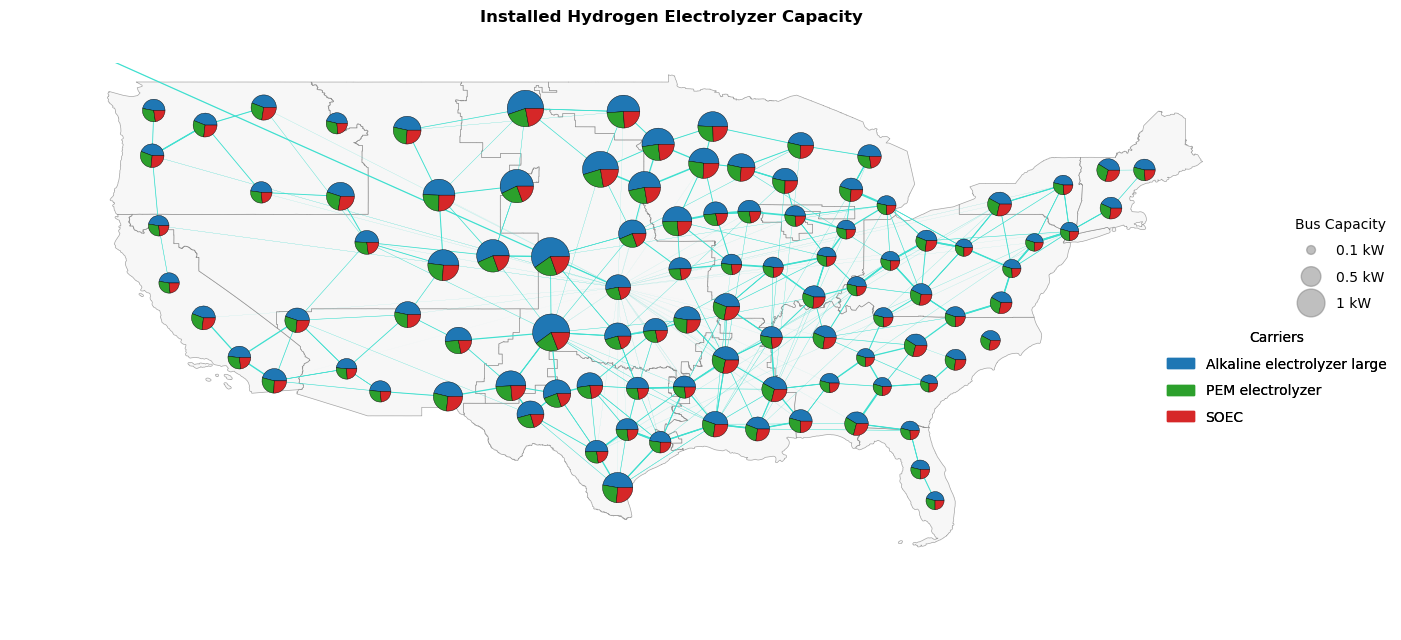

In [ ]:
for n in networks.keys():
    valid_buses = network.buses.dropna(subset=["x", "y"])
    valid_buses = valid_buses[
        (valid_buses["x"] > -200) & (valid_buses["x"] < 200) &
        (valid_buses["y"] > -90) & (valid_buses["y"] < 90)
    ]

    fig, ax = plt.subplots(figsize=(14, 10), subplot_kw={"projection": ccrs.PlateCarree()})
    bbox = box(-130, 20, -60, 50)
    regions_onshore_clipped = regions_onshore.to_crs(epsg=4326).clip(bbox)
    regions_onshore_clipped.plot(
            ax=ax,
            facecolor='whitesmoke',
            edgecolor='gray',
            alpha=0.7,
            linewidth=0.5,
            zorder=0,
        )

    line_scale = 5e-3
    network.plot(
            ax=ax,
            bus_sizes=0,
            bus_alpha=0,
            # line_widths=network.lines.s_nom_opt / line_scale,
            link_widths=network.links.p_nom_opt / line_scale,
            line_colors='teal',
            link_colors='turquoise',
            color_geomap=False,
            flow=None,
            branch_components=['Link'],
            boundaries=[-130, -60, 20, 50],  # view showing
        )
    pie_scale = 1

    for bus_id, capacities in h2_capacity_data.iterrows():
        x, y = valid_buses.loc[bus_id, ['x', 'y']]
        if not bbox.contains(gpd.points_from_xy([x], [y])[0]):
            continue

        values = capacities.values
        total = values.sum()
        if total == 0:
            continue

        size = np.clip(np.sqrt(total) * pie_scale, 0.1, 1.5)
        colors = [tech_colors.get(c, 'gray') for c in capacities.index]
        
        start_angle = 0
        for val, color in zip(values, colors):
            if val == 0:
                continue
            angle = 360 * val / total  # proporzione rispetto al totale del nodo
            wedge = Wedge(
                center=(x, y),
                r=size,
                theta1=start_angle,
                theta2=start_angle + angle,
                facecolor=color,
                edgecolor='k',
                linewidth=0.3,
                transform=ccrs.PlateCarree()._as_mpl_transform(ax),
                zorder=5,
            )
            ax.add_patch(wedge)
            start_angle += angle
            # ax.annotate(f'{total:.02f} kW', 
            #            xy=(x, y - size - 0.3), 
            #            ha='center', va='top', fontsize=5, fontweight='bold')

    class HandlerCircle(HandlerPatch):
        def create_artists(self, legend, orig_handle,
                            xdescent, ydescent, width, height, fontsize, trans):
            center = (width / 2, height / 2)
            radius = orig_handle.get_radius()
            p = plt.Circle(center, radius)
            self.update_prop(p, orig_handle, legend)
            p.set_transform(trans)
            return [p]

    # Legends
    bus_caps = [0.1, 0.5, 1]
    bus_patches = []
    for cap in bus_caps:
        r_in_map = np.sqrt(cap)
        r_pts = r_in_map * fig.dpi * 2
        circ = plt.Circle((0, 0), radius=r_pts / 0.2 / fig.dpi, color='gray', alpha=0.5)
        bus_patches.append(circ)

    bus_legend = ax.legend(
        bus_patches,
        [f"{cap} kW" for cap in bus_caps],
        title="Bus Capacity",
        title_fontsize=10,
        fontsize=10,
        frameon=False,
        handler_map={mpatches.Circle: HandlerCircle()},
        loc='upper right',
        bbox_to_anchor=(1.05, 0.75),
        labelspacing=0.9,
    )


    carrier_handles = [
            mpatches.Patch(color=tech_colors.get(c, 'gray'), label=nice_names.get(c, c))
            for c in sorted(h2_capacity_data.columns) if h2_capacity_data[c].sum() > 0
        ]
    carrier_legend = ax.legend(
        handles=carrier_handles,
        title="Carriers",
        title_fontsize=10,
        fontsize=10,
        frameon=False,
        loc='upper right',
        bbox_to_anchor=(1.05, 0.55),
        ncol=1,
        labelspacing=0.9,
    )

    ax.add_artist(bus_legend)
    ax.add_artist(carrier_legend)

    ax.set_extent([-130, -60, 20, 50], crs=ccrs.PlateCarree())
    ax.autoscale(False)

    ax.set_title('Installed Hydrogen Electrolyzer Capacity', 
                fontsize=12, fontweight='bold', pad=30)
        
    plt.tight_layout()
    plt.show()

Found hydrogen capacity data for 45 states
Electrolyzer types found: ['Alkaline electrolyzer large', 'PEM electrolyzer', 'SOEC']
Plotting 43 states with ≥0.001 MW hydrogen capacity


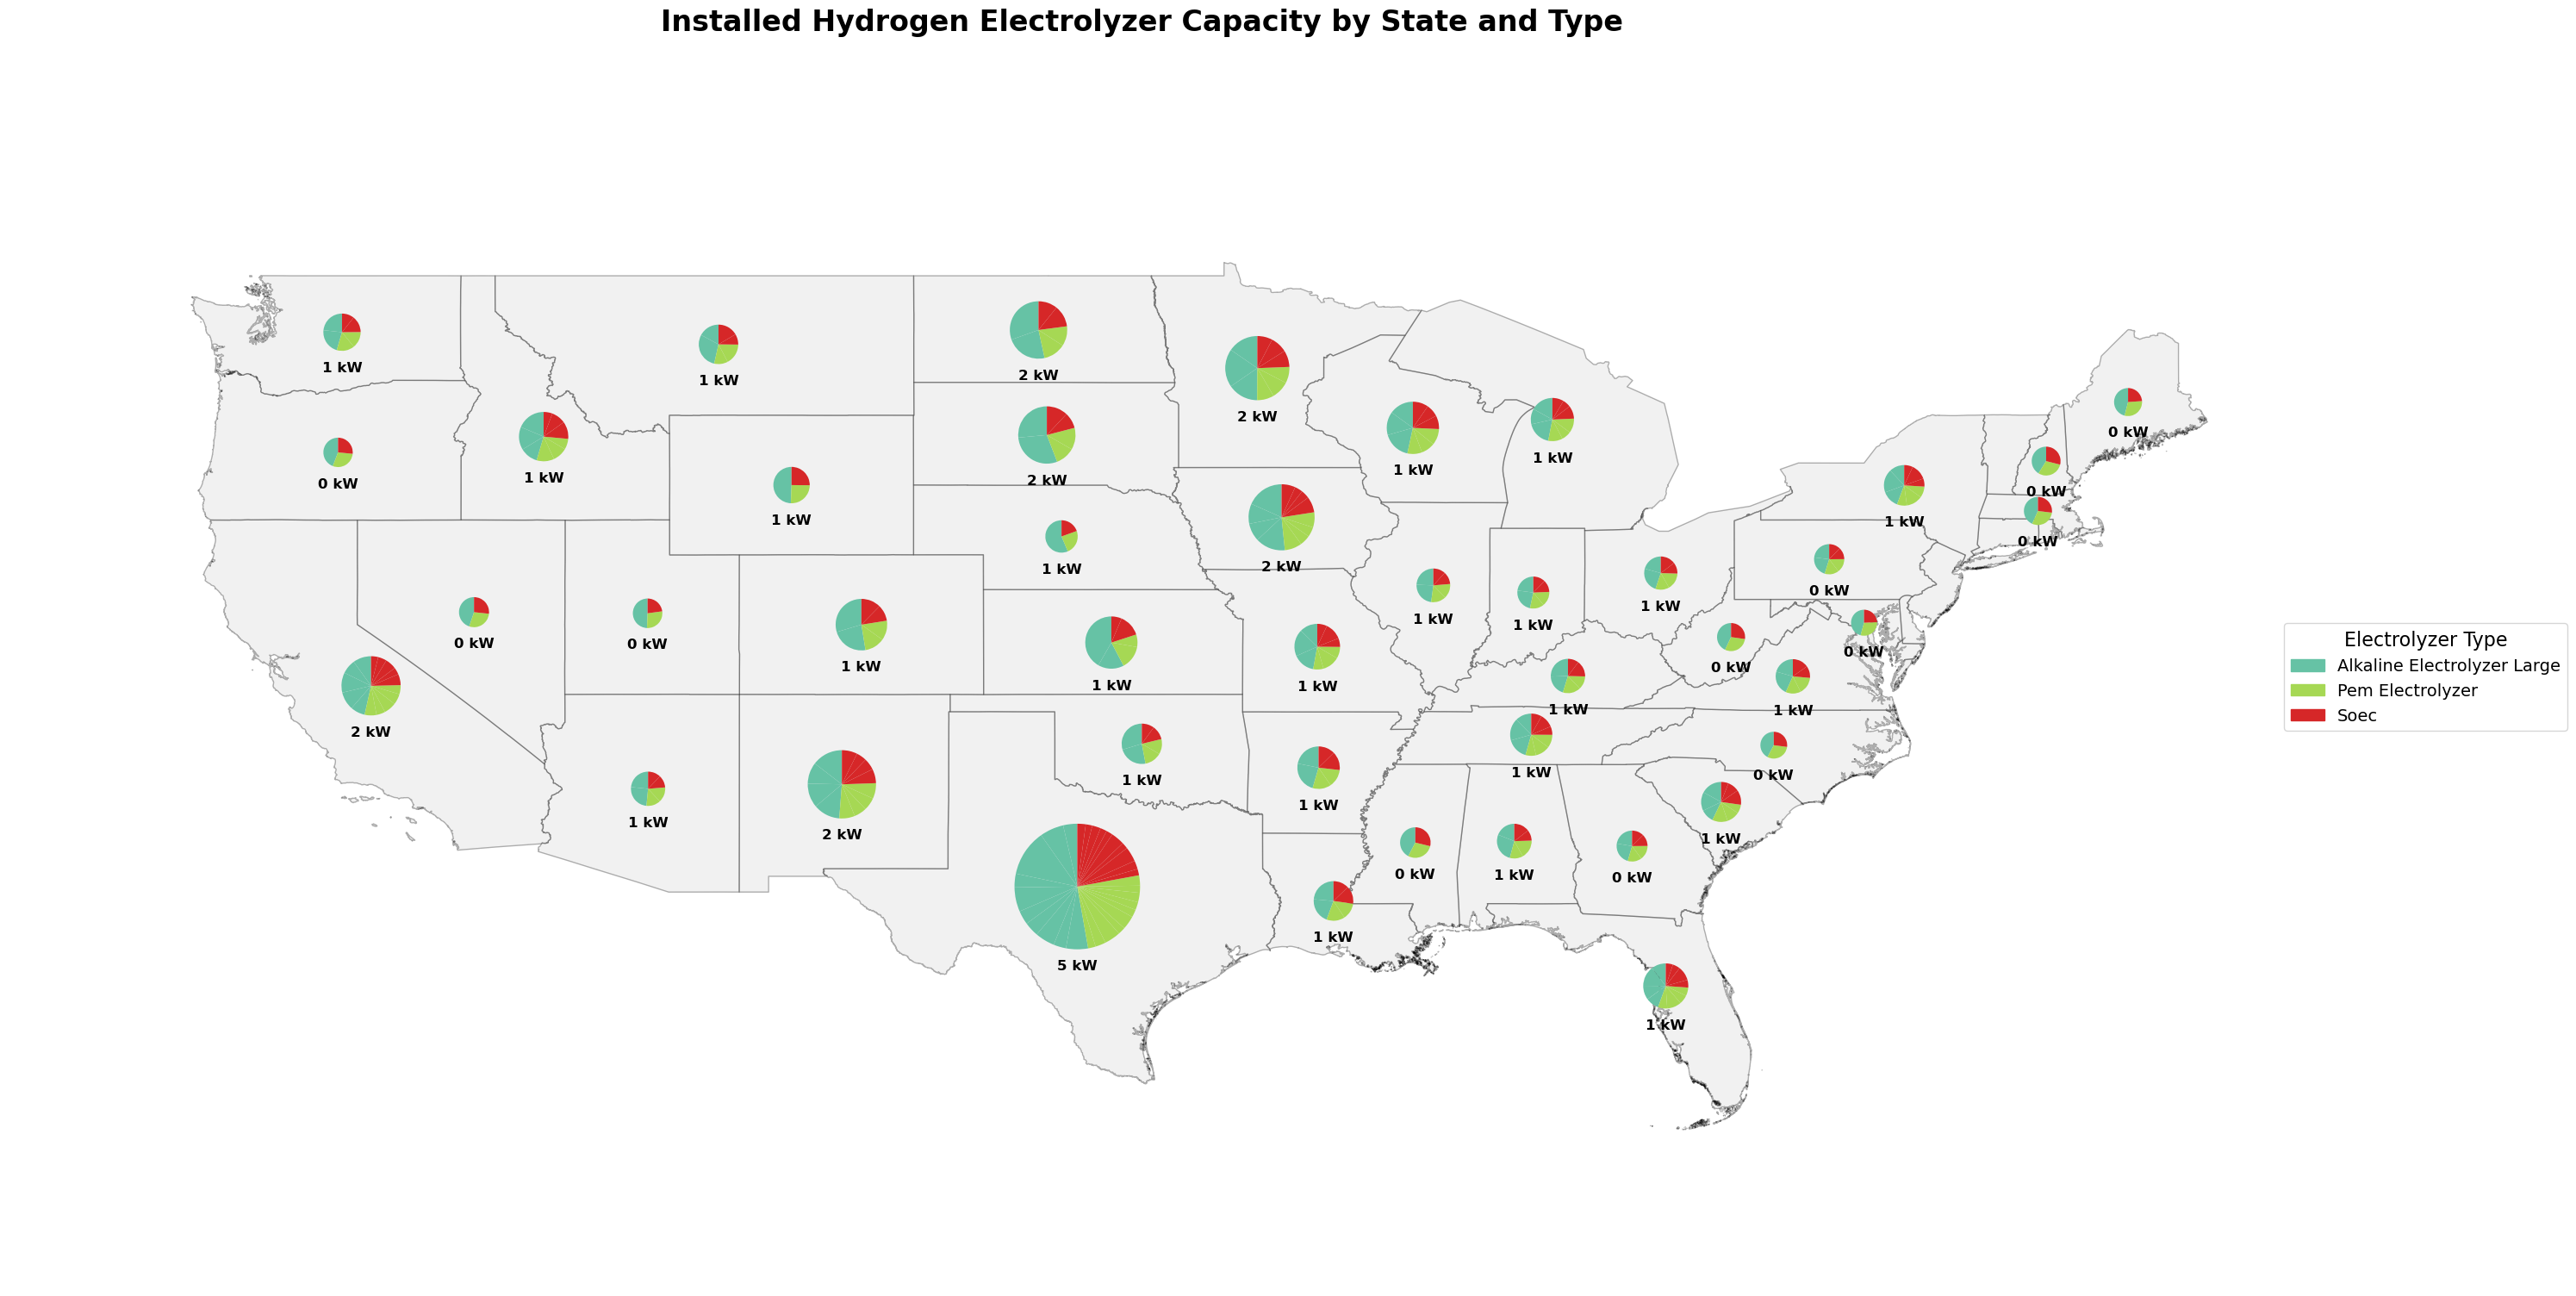

In [ ]:
def create_hydrogen_capacity_map(network, path_shapes, distance_crs=4326, min_capacity_mw=10):
    """
    Create a map with pie charts showing hydrogen electrolyzer capacity breakdown by type for each state
    """

    hydrogen_links = network.links.query("carrier in @h2_carriers").copy()
    
    capacity_data = hydrogen_links.merge(
                network.buses[['state']], 
                left_on='bus0',  # Assuming bus0 is the electrical connection
                right_index=True, 
                how='left'
            )
        
    # Convert MW to kW
    capacity_data['p_nom_kw'] = capacity_data['p_nom_opt'] * 1000
    
    print(f"Found hydrogen capacity data for {capacity_data['state'].nunique()} states")
    print("Electrolyzer types found:", capacity_data['carrier'].unique().tolist())
    
    # Step 2: Read and prepare shapefile
    shapes = gpd.read_file(path_shapes, crs=distance_crs)
    shapes["ISO_1"] = shapes["ISO_1"].apply(lambda x: x.split("-")[1])
    shapes.rename(columns={"ISO_1": "State"}, inplace=True)
    
    # Get state centroids for pie chart placement
    shapes_centroid = shapes.copy()
    shapes_centroid['centroid'] = shapes_centroid.geometry.centroid
    shapes_centroid['cent_x'] = shapes_centroid.centroid.x
    shapes_centroid['cent_y'] = shapes_centroid.centroid.y
    
    # Step 3: Define colors for electrolyzer types
    unique_carriers = capacity_data['carrier'].unique()
    colors = plt.cm.Set2(np.linspace(0, 1, len(unique_carriers)))
    carrier_colors = dict(zip(unique_carriers, colors))
    
    # Customize colors for common electrolyzer types
    custom_colors = {
        'H2 Electrolysis': '#1f77b4',           # Blue
        'alkaline': '#ff7f0e',                  # Orange  
        'PEM': '#2ca02c',                       # Green
        'SOEC': '#d62728',                      # Red
        'AEL': '#9467bd',                       # Purple
        'electrolyzer': '#8c564b',              # Brown
        'hydrogen': '#e377c2',                  # Pink
        'H2': '#7f7f7f',                        # Gray
    }
    
    # Update carrier_colors with custom colors
    for carrier, color in custom_colors.items():
        if carrier in carrier_colors:
            carrier_colors[carrier] = color
    
    # Step 4: Create the plot
    fig, ax = plt.subplots(figsize=(30, 20))
    
    # Plot the base map
    shapes.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.3)
    
    # Group capacity data by state
    state_capacity = capacity_data.groupby('state').agg({
        'p_nom_kw': 'sum'
    }).reset_index()
    
    # Filter states with minimum capacity
    states_to_plot = state_capacity['state'].tolist()
    states_to_plot = [state for state in states_to_plot if state not in ['AK', 'HI']]
    
    print(f"Plotting {len(states_to_plot)} states with ≥{min_capacity_mw} MW hydrogen capacity")
    
    # Step 5: Create pie charts for each state
    for state in states_to_plot:
        state_data = capacity_data[capacity_data['state'] == state]
        
        if len(state_data) == 0:
            continue
            
        # Get state centroid
        state_centroid = shapes_centroid[shapes_centroid['State'] == state]
        if len(state_centroid) == 0:
            continue
            
        cent_x = state_centroid['cent_x'].iloc[0]
        cent_y = state_centroid['cent_y'].iloc[0]
        
        # Prepare pie chart data
        sizes = state_data['p_nom_kw'].values
        labels = state_data['carrier'].values
        colors_list = [carrier_colors[carrier] for carrier in labels]
        
        # Calculate pie chart radius based on total capacity
        total_capacity = sizes.sum()
        # Scale radius based on capacity (adjusted for MW scale)
        max_capacity = state_capacity['p_nom_kw'].max()
        radius = 0.3 + (total_capacity / max_capacity) * 1.5
        
        # Create pie chart
        pie_wedges, texts = ax.pie(sizes, colors=colors_list, center=(cent_x, cent_y), 
                                  radius=radius, startangle=90)
        
        # Add capacity label
        ax.annotate(f'{total_capacity:.0f} kW', 
                   xy=(cent_x, cent_y - radius - 0.3), 
                   ha='center', va='top', fontsize=12, fontweight='bold')
    
    # Step 6: Create legend
    legend_elements = []
    for carrier, color in carrier_colors.items():
        if carrier in capacity_data['carrier'].values:
            # Clean up carrier names for legend
            display_name = carrier.replace('_', ' ').title()
            legend_elements.append(mpatches.Patch(color=color, label=display_name))
    
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), 
             fontsize=14, title='Electrolyzer Type', title_fontsize=16)
    
    # Step 7: Formatting - Expand map boundaries
    x_buffer = (shapes.total_bounds[2] - shapes.total_bounds[0]) * 0.1
    y_buffer = (shapes.total_bounds[3] - shapes.total_bounds[1]) * 0.1
    
    ax.set_xlim([-130, -65])
    ax.set_ylim([20,55])
    ax.set_aspect('equal')
    ax.axis('off')
    
    ax.set_title('Installed Hydrogen Electrolyzer Capacity by State and Type', 
                fontsize=24, fontweight='bold', pad=30)
    
    # Add subtitle
    # ax.text(0.5, 0.02, f'Note: Only states with ≥{min_capacity_mw} MW electrolyzer capacity are shown', 
    #        transform=ax.transAxes, ha='center', fontsize=14, style='italic')
    
    plt.tight_layout()
    return fig, ax, capacity_data

# def print_hydrogen_capacity_summary(capacity_data):
#     """Print summary statistics of the hydrogen capacity data"""
#     if len(capacity_data) == 0:
#         print("No hydrogen capacity data to summarize.")
#         return
        
#     print("=== HYDROGEN ELECTROLYZER CAPACITY SUMMARY ===")
#     print(f"Total installed hydrogen capacity: {capacity_data['p_nom'].sum():.1f} MW")
#     print(f"Number of states with hydrogen capacity: {capacity_data['state'].nunique()}")
#     print(f"Number of electrolyzer types: {capacity_data['carrier'].nunique()}")
    
#     print("\n=== TOP 10 STATES BY HYDROGEN CAPACITY ===")
#     state_totals = capacity_data.groupby('state')['p_nom'].sum().sort_values(ascending=False)
#     for i, (state, capacity) in enumerate(state_totals.head(10).items()):
#         print(f"{i+1:2d}. {state}: {capacity:.1f} MW")
    
#     print("\n=== ELECTROLYZER TYPE MIX (NATIONAL) ===")
#     carrier_totals = capacity_data.groupby('carrier')['p_nom'].sum().sort_values(ascending=False)
#     total_national = carrier_totals.sum()
#     for carrier, capacity in carrier_totals.items():
#         print(f"{carrier:25s}: {capacity:8.1f} MW ({capacity/total_national*100:5.1f}%)")

n = networks["scenario_01_2030"].copy()

fig, ax, capacity_data = create_hydrogen_capacity_map(
    n, 
    state_shapes_path, 
    min_capacity_mw=10 * 0.0001  # Only show states with at least 50 MW
)


Found hydrogen capacity data for 45 states
Electrolyzer types found: ['Alkaline electrolyzer large', 'PEM electrolyzer', 'SOEC', 'H2 Fuel Cell', 'H2 pipeline repurposed', 'H2 pipeline', 'grid H2', 'H2']
Plotting 45 states with ≥0.001 MW hydrogen capacity


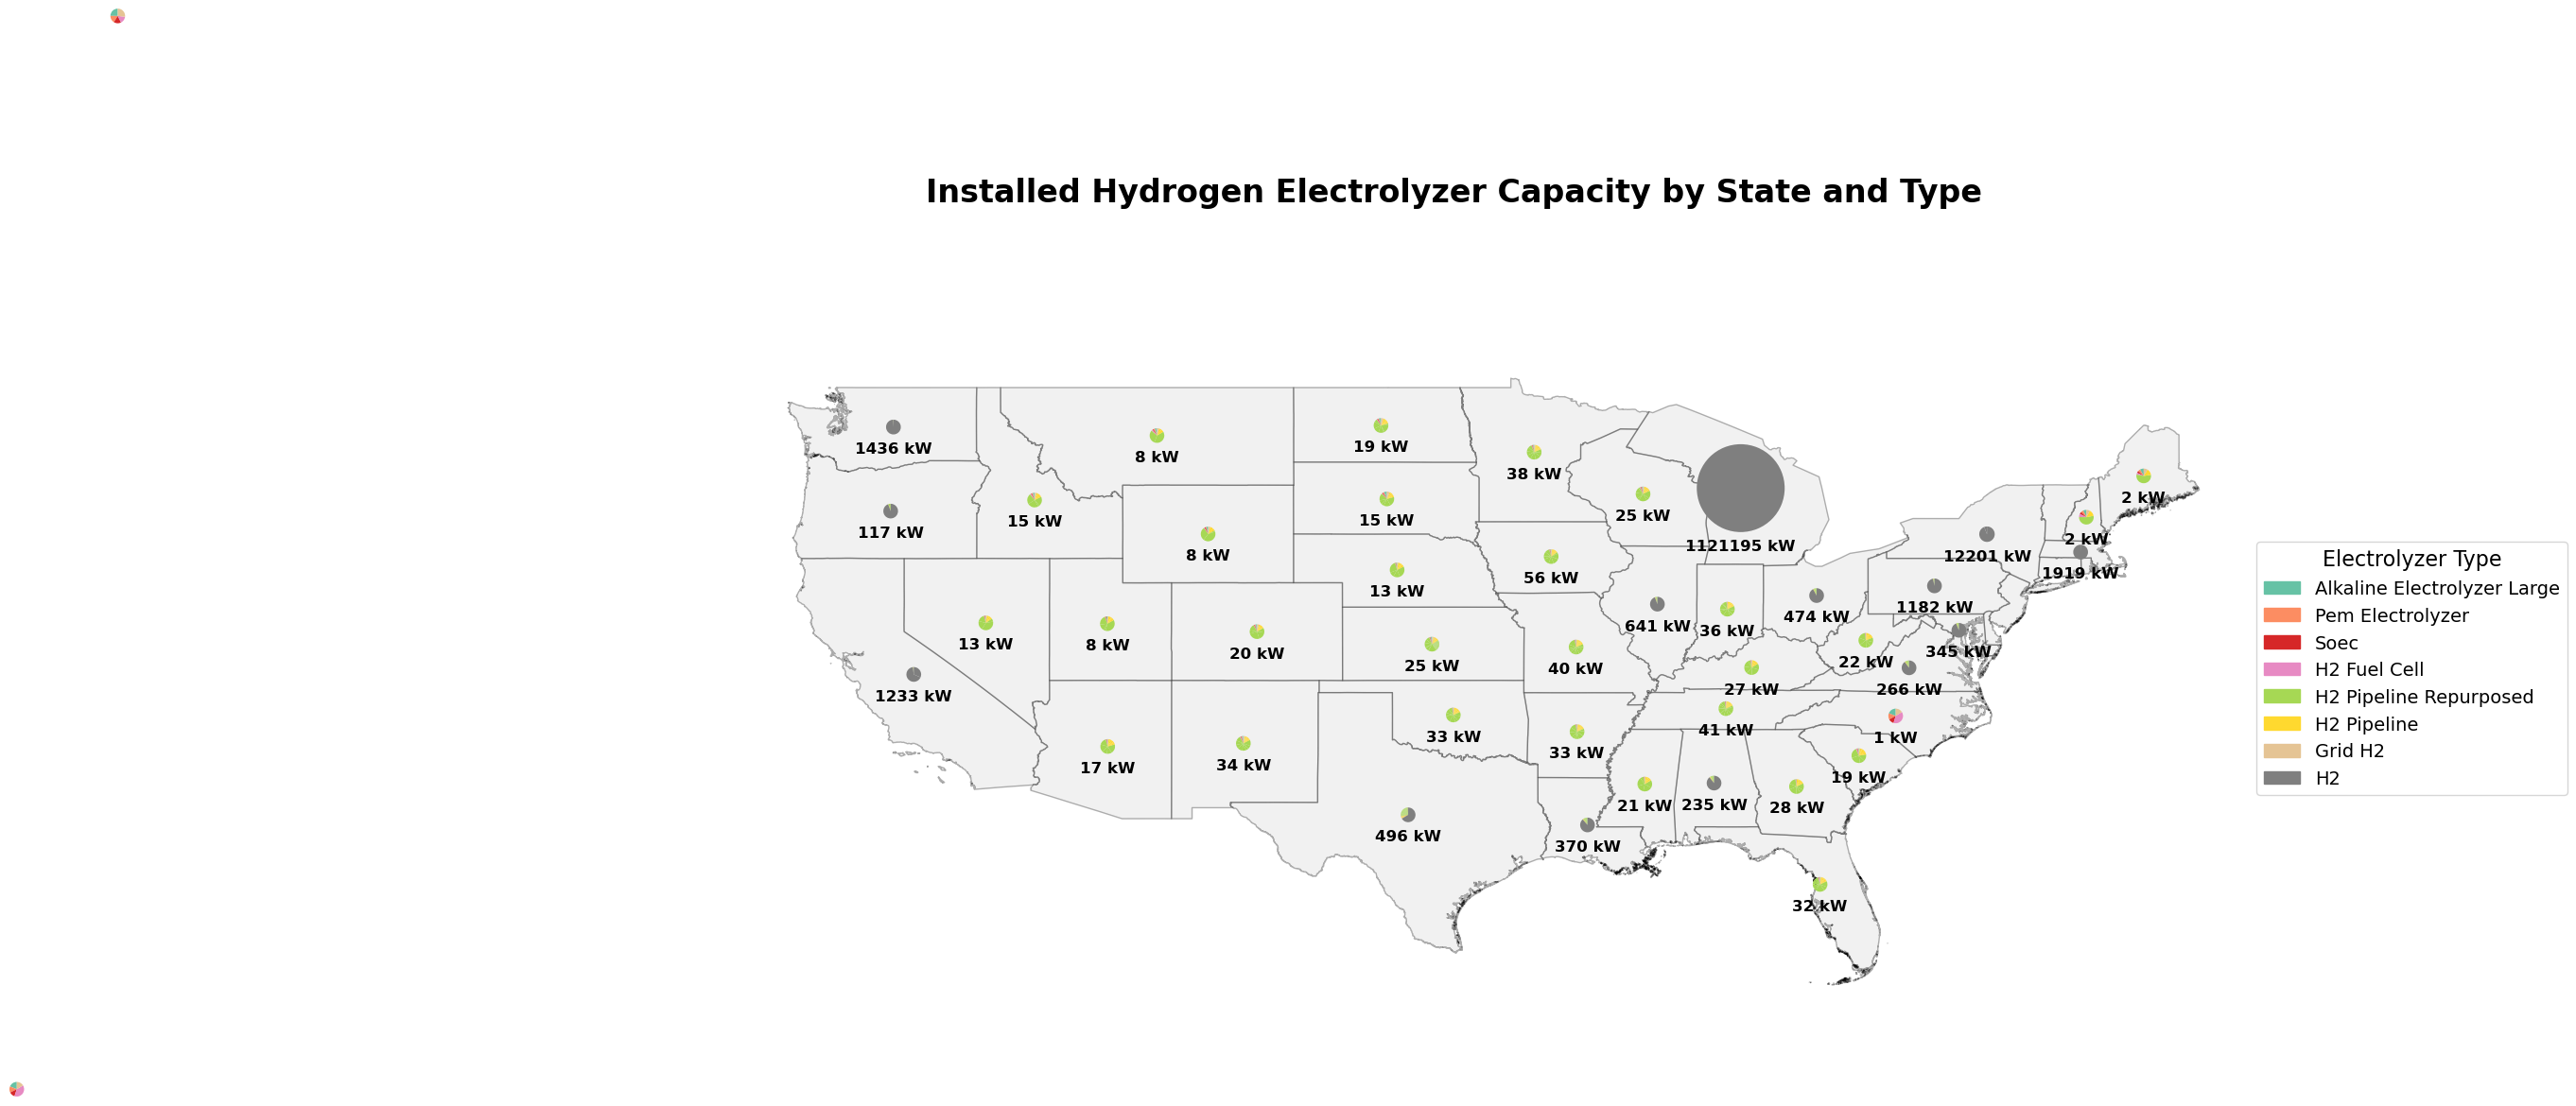

In [ ]:
n = networks["scenario_01_2030"].copy()

fig, ax, capacity_data = create_hydrogen_capacity_map(
    n, 
    state_shapes_path, 
    min_capacity_mw=10 * 0.0001  # Only show states with at least 50 MW
)

In [ ]:
print_hydrogen_capacity_summary(capacity_data)

=== HYDROGEN ELECTROLYZER CAPACITY SUMMARY ===
Total installed hydrogen capacity: 0.0 MW
Number of states with hydrogen capacity: 11
Number of electrolyzer types: 5

=== TOP 10 STATES BY HYDROGEN CAPACITY ===
 1. AR: 0.0 MW
 2. CA: 0.0 MW
 3. GA: 0.0 MW
 4. IA: 0.0 MW
 5. IN: 0.0 MW
 6. NH: 0.0 MW
 7. NY: 0.0 MW
 8. OR: 0.0 MW
 9. TX: 0.0 MW
10. WV: 0.0 MW

=== ELECTROLYZER TYPE MIX (NATIONAL) ===
H2                       :      0.0 MW (  nan%)
H2 Electrolysis          :      0.0 MW (  nan%)
H2 Fuel Cell             :      0.0 MW (  nan%)
H2 pipeline              :      0.0 MW (  nan%)
H2 pipeline repurposed   :      0.0 MW (  nan%)


In [ ]:
network = networks['scenario_01_2030'].copy()

In [ ]:
h2_carriers_links = ['H2 pipeline repurposed', 'H2 pipeline']
h2_carriers_buses = ['Alkaline electrolyzer large', 'PEM electrolyzer', 'SOEC',]

In [ ]:
hydrogen_links = network.links.query("carrier in @h2_carriers_buses").copy()
capacity_data = hydrogen_links.merge(
                network.buses[['state']], 
                left_on='bus0',  # Assuming bus0 is the electrical connection
                right_index=True, 
                how='left'
            )
capacity_data['p_nom_kw'] = capacity_data['p_nom_opt'] * 1000


In [ ]:
h2_capacity_data = capacity_data.pivot_table(
    index='bus0',
    columns='carrier',
    values='p_nom_kw',
    fill_value=0
)

In [ ]:
network.links.query("carrier in @h2_carriers_links", inplace=True)

In [ ]:
valid_buses = network.buses.dropna(subset=["x", "y"])
valid_buses = valid_buses[
    (valid_buses["x"] > -200) & (valid_buses["x"] < 200) &
    (valid_buses["y"] > -90) & (valid_buses["y"] < 90)
]
    

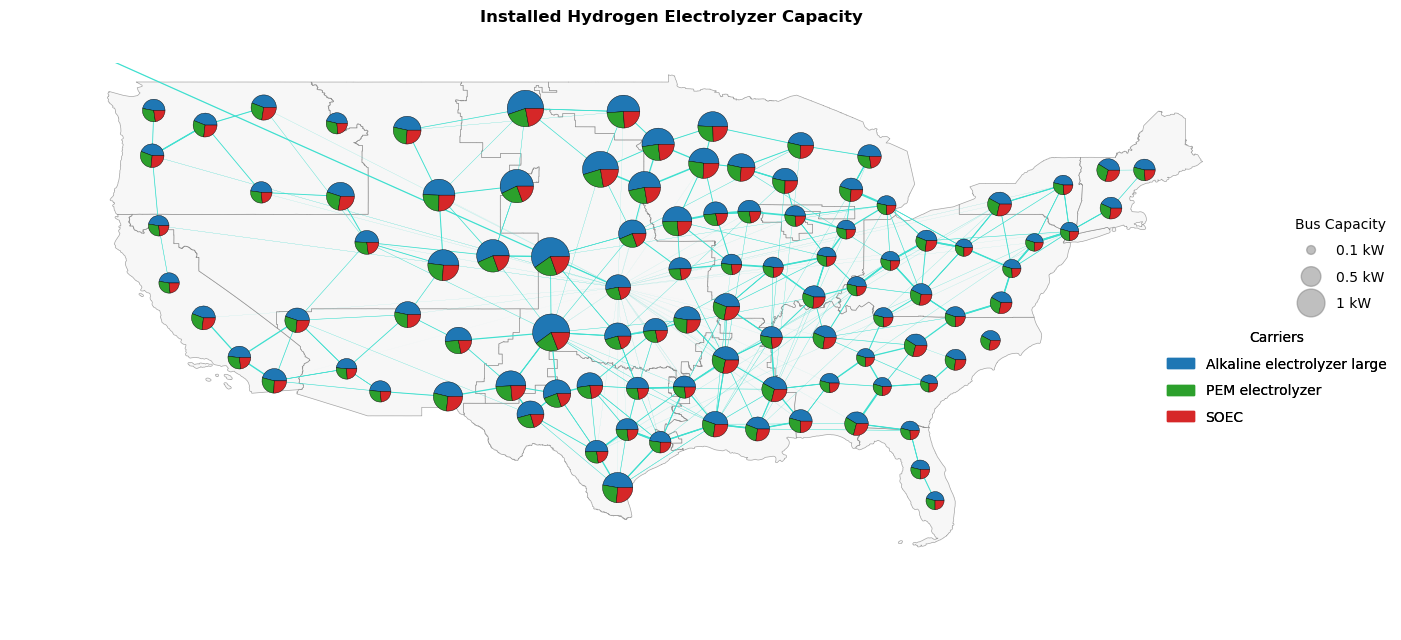

In [ ]:
fig, ax = plt.subplots(figsize=(14, 10), subplot_kw={"projection": ccrs.PlateCarree()})
bbox = box(-130, 20, -60, 50)
regions_onshore_clipped = regions_onshore.to_crs(epsg=4326).clip(bbox)
regions_onshore_clipped.plot(
        ax=ax,
        facecolor='whitesmoke',
        edgecolor='gray',
        alpha=0.7,
        linewidth=0.5,
        zorder=0,
    )

line_scale = 5e-3
network.plot(
        ax=ax,
        bus_sizes=0,
        bus_alpha=0,
        # line_widths=network.lines.s_nom_opt / line_scale,
        link_widths=network.links.p_nom_opt / line_scale,
        line_colors='teal',
        link_colors='turquoise',
        color_geomap=False,
        flow=None,
        branch_components=['Link'],
        boundaries=[-130, -60, 20, 50],  # view showing
    )
pie_scale = 1

for bus_id, capacities in h2_capacity_data.iterrows():
    x, y = valid_buses.loc[bus_id, ['x', 'y']]
    if not bbox.contains(gpd.points_from_xy([x], [y])[0]):
        continue

    values = capacities.values
    total = values.sum()
    if total == 0:
        continue

    size = np.clip(np.sqrt(total) * pie_scale, 0.1, 1.5)
    colors = [tech_colors.get(c, 'gray') for c in capacities.index]
    
    start_angle = 0
    for val, color in zip(values, colors):
        if val == 0:
            continue
        angle = 360 * val / total  # proporzione rispetto al totale del nodo
        wedge = Wedge(
            center=(x, y),
            r=size,
            theta1=start_angle,
            theta2=start_angle + angle,
            facecolor=color,
            edgecolor='k',
            linewidth=0.3,
            transform=ccrs.PlateCarree()._as_mpl_transform(ax),
            zorder=5,
        )
        ax.add_patch(wedge)
        start_angle += angle
        # ax.annotate(f'{total:.02f} kW', 
        #            xy=(x, y - size - 0.3), 
        #            ha='center', va='top', fontsize=5, fontweight='bold')

class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                        xdescent, ydescent, width, height, fontsize, trans):
        center = (width / 2, height / 2)
        radius = orig_handle.get_radius()
        p = plt.Circle(center, radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

# Legends
bus_caps = [0.1, 0.5, 1]
bus_patches = []
for cap in bus_caps:
    r_in_map = np.sqrt(cap)
    r_pts = r_in_map * fig.dpi * 2
    circ = plt.Circle((0, 0), radius=r_pts / 0.2 / fig.dpi, color='gray', alpha=0.5)
    bus_patches.append(circ)

bus_legend = ax.legend(
    bus_patches,
    [f"{cap} kW" for cap in bus_caps],
    title="Bus Capacity",
    title_fontsize=10,
    fontsize=10,
    frameon=False,
    handler_map={mpatches.Circle: HandlerCircle()},
    loc='upper right',
    bbox_to_anchor=(1.05, 0.75),
    labelspacing=0.9,
)


carrier_handles = [
        mpatches.Patch(color=tech_colors.get(c, 'gray'), label=nice_names.get(c, c))
        for c in sorted(h2_capacity_data.columns) if h2_capacity_data[c].sum() > 0
    ]
carrier_legend = ax.legend(
    handles=carrier_handles,
    title="Carriers",
    title_fontsize=10,
    fontsize=10,
    frameon=False,
    loc='upper right',
    bbox_to_anchor=(1.05, 0.55),
    ncol=1,
    labelspacing=0.9,
)

ax.add_artist(bus_legend)
ax.add_artist(carrier_legend)

ax.set_extent([-130, -60, 20, 50], crs=ccrs.PlateCarree())
ax.autoscale(False)

ax.set_title('Installed Hydrogen Electrolyzer Capacity', 
            fontsize=12, fontweight='bold', pad=30)
    
plt.tight_layout()
plt.show()

In [ ]:
h2_capacity_data

carrier  Alkaline electrolyzer large  PEM electrolyzer      SOEC
bus0                                                            
US0 0                       0.418911          0.177565  0.143813
US0 1                       0.150244          0.108978  0.105535
US0 10                      0.116407          0.073417  0.061417
US0 11                      0.158138          0.104088  0.093828
US0 12                      0.146589          0.095989  0.074044
...                              ...               ...       ...
US0 96                      0.156002          0.088078  0.081836
US0 97                      0.275533          0.128665  0.104252
US0 98                      0.324396          0.175113  0.174757
US0 99                      0.153969          0.092259  0.075784
US1 0                       0.150859          0.109633  0.106219

[101 rows x 3 columns]

In [ ]:
h2_capacity_data['state'] = h2_capacity_data.index.map(network.buses.state)
h2_capacity_data['region'] = h2_capacity_data.index.map(network.buses.region)

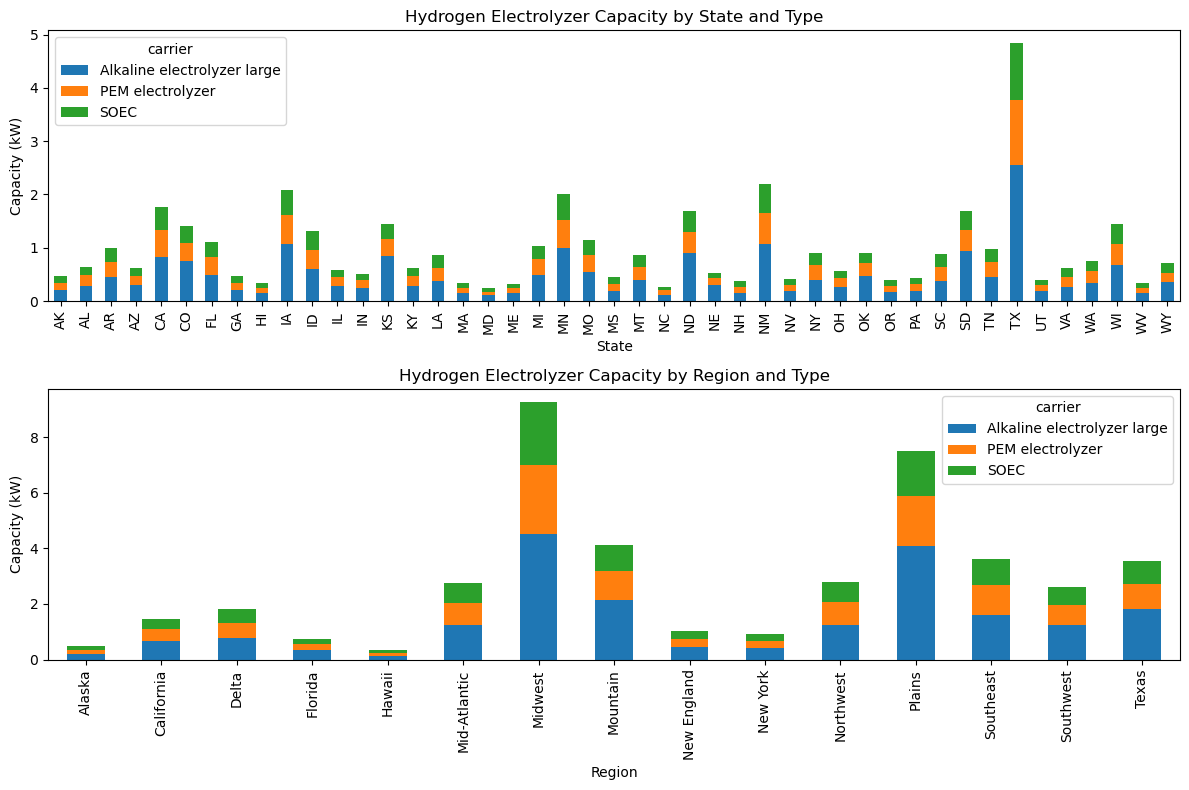

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
h2_capacity_data.groupby(['state'])[['Alkaline electrolyzer large',	'PEM electrolyzer', 'SOEC']].sum().plot(
    ax=ax1,
    kind='bar',
    stacked=True,
    title='Hydrogen Electrolyzer Capacity by State and Type',
    ylabel='Capacity (kW)',
    xlabel='State',
)

h2_capacity_data.groupby(['region'])[['Alkaline electrolyzer large', 'PEM electrolyzer', 'SOEC']].sum().plot(
    ax=ax2,
    kind='bar',
    stacked=True,
    title='Hydrogen Electrolyzer Capacity by Region and Type',
    ylabel='Capacity (kW)',
    xlabel='Region',
)

plt.tight_layout()
plt.show()

### 4.3. Map: Total Installed Fischer-Tropsch (FT) Capacity
*A map showing where FT synthesis plants are built and their respective capacities, crucial for e-fuel production.*

In [ ]:
networks.keys()

dict_keys(['Base Scenario', 'Scenario A', 'Scenario B'])

In [ ]:
n = networks["Scenario A"].copy()

In [ ]:
ft_links = n.links[
        n.links['carrier'].str.contains('FT|Fischer|Tropsch', case=False, na=False) |
        n.links.index.str.contains('FT|Fischer|Tropsch', case=False, na=False)
    ].copy()

In [ ]:
ft_links.p_nom_opt

Link
US0 0 Fischer-Tropsch-2030      0.228620
US0 1 Fischer-Tropsch-2030      0.205218
US0 2 Fischer-Tropsch-2030    855.146744
US0 3 Fischer-Tropsch-2030      0.127410
US0 4 Fischer-Tropsch-2030      0.172792
US0 5 Fischer-Tropsch-2030      0.262672
US0 6 Fischer-Tropsch-2030      0.230836
US0 7 Fischer-Tropsch-2030    437.859706
US0 8 Fischer-Tropsch-2030      0.126185
US0 9 Fischer-Tropsch-2030      0.239974
US1 0 Fischer-Tropsch-2030      0.181522
Name: p_nom_opt, dtype: float64

In [ ]:
def create_ft_capacity_map(network, path_shapes, distance_crs=4326, min_capacity_mw=10):
    """
    Create a map with pie charts showing FT (Fischer-Tropsch) capacity breakdown by type for each state
    """
    # Filter for FT-related links (Fischer-Tropsch synthesis units)
    ft_links = network.links[
        network.links['carrier'].str.contains('FT|Fischer|Tropsch', case=False, na=False) |
        network.links.index.str.contains('FT|Fischer|Tropsch', case=False, na=False)
    ].copy()
    
    if ft_links.empty:
        print("No FT links found in the network.")
        return None, None, None

    # Attach state info
    links_with_state = ft_links.merge(
        network.buses[['state']],
        left_on='bus0',
        right_index=True,
        how='left'
    )
    links_with_state['p_nom_mw'] = links_with_state['p_nom_opt']

    # Read and prepare shapefile
    shapes = gpd.read_file(path_shapes, crs=distance_crs)
    shapes["ISO_1"] = shapes["ISO_1"].apply(lambda x: x.split("-")[1])
    shapes.rename(columns={"ISO_1": "State"}, inplace=True)
    shapes_centroid = shapes.copy()
    shapes_centroid['centroid'] = shapes_centroid.geometry.centroid
    shapes_centroid['cent_x'] = shapes_centroid.centroid.x
    shapes_centroid['cent_y'] = shapes_centroid.centroid.y

    # Colors for FT types
    unique_carriers = links_with_state['carrier'].unique()
    colors = plt.cm.Paired(np.linspace(0, 1, len(unique_carriers)))
    carrier_colors = dict(zip(unique_carriers, colors))
    custom_colors = {
        'FT': '#8B0000',
        'fischer-tropsch': '#B22222',
        'fischer_tropsch': '#B22222',
        'Fischer-Tropsch': '#B22222',
    }
    for carrier, color in custom_colors.items():
        for uc in unique_carriers:
            if carrier.lower() in uc.lower():
                carrier_colors[uc] = color

    # Group capacity data by state
    state_capacity = links_with_state.groupby('state').agg({'p_nom_opt': 'sum'}).reset_index()
    states_to_plot = state_capacity[state_capacity['p_nom_opt'] >= min_capacity_mw]['state'].tolist()

    fig, ax = plt.subplots(figsize=(20, 15))
    shapes.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.3)

    for state in states_to_plot:
        state_data = links_with_state[links_with_state['state'] == state]
        if len(state_data) == 0:
            continue
        state_centroid = shapes_centroid[shapes_centroid['State'] == state]
        if len(state_centroid) == 0:
            continue
        cent_x = state_centroid['cent_x'].iloc[0]
        cent_y = state_centroid['cent_y'].iloc[0]
        sizes = state_data['p_nom_opt'].values
        labels = state_data['carrier'].values
        colors_list = [carrier_colors[carrier] for carrier in labels]
        total_capacity = sizes.sum()
        max_capacity = state_capacity['p_nom_opt'].max()
        radius = 0.3 + (total_capacity / max_capacity) * 1.5
        pie_wedges, texts = ax.pie(sizes, colors=colors_list, center=(cent_x, cent_y),
                                   radius=radius, startangle=90)
        ax.annotate(f'{total_capacity:.5f} MW',
                    xy=(cent_x, cent_y - radius - 0.3),
                    ha='center', va='top', fontsize=12, fontweight='bold')

    # Legend
    legend_elements = []
    for carrier, color in carrier_colors.items():
        if carrier in links_with_state['carrier'].values:
            display_name = carrier.replace('_', ' ').title()
            legend_elements.append(mpatches.Patch(color=color, label=display_name))
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5),
              fontsize=14, title='FT Type', title_fontsize=16)

    ax.set_xlim([-130, -65])
    ax.set_ylim([20, 55])
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('Installed Fischer-Tropsch Capacity by State and Type',
                 fontsize=20, fontweight='bold', pad=30)
    ax.text(0.5, 0.02, f'Note: Only states with ≥{min_capacity_mw} MW FT capacity are shown',
            transform=ax.transAxes, ha='center', fontsize=12, style='italic')
    plt.tight_layout()
    return fig, ax, links_with_state



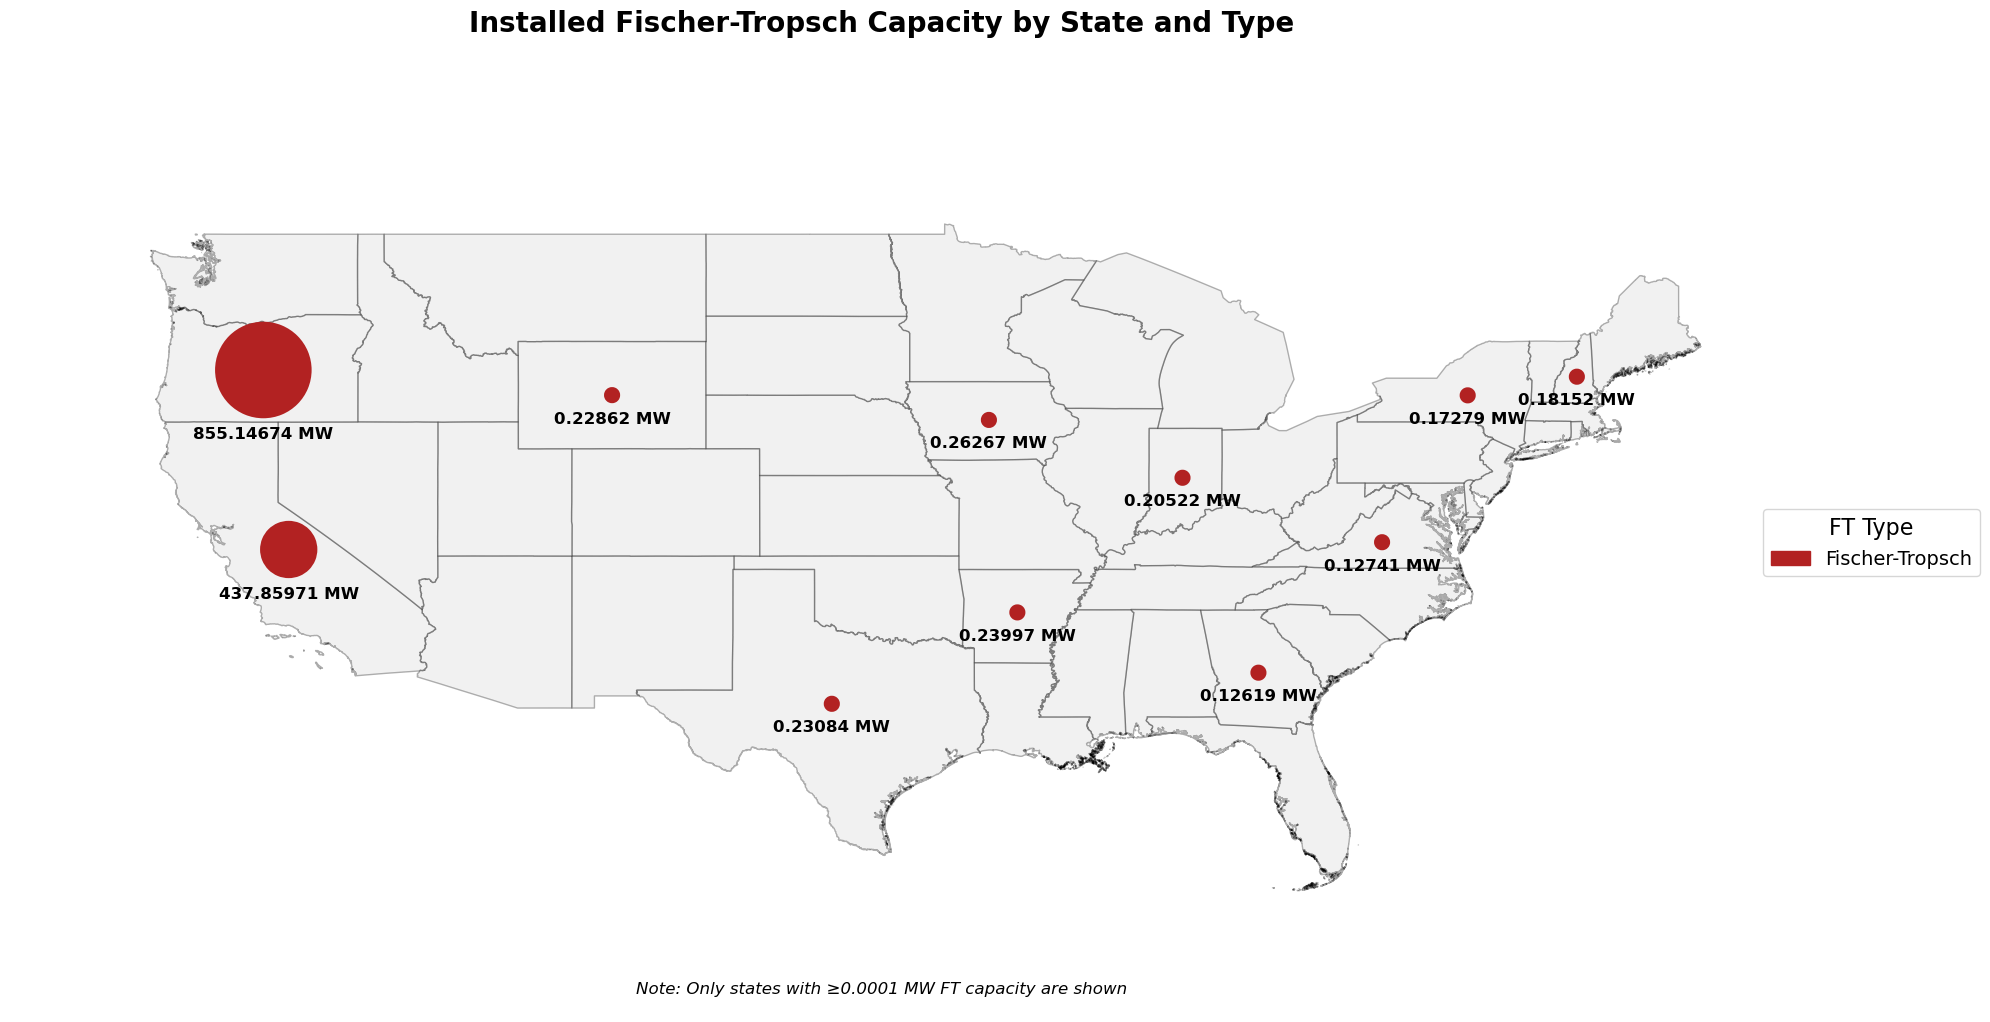

In [ ]:
fig, ax, ft_capacity_data = create_ft_capacity_map(
    n,
    state_shapes_path,
    min_capacity_mw=0.0001
)

### 4.4. Map: Expanded Capacity per Planning Horizon
*This analysis focuses only on the **newly added** capacity for key technologies (Electricity, H2, FT) within the planning period, rather than the total capacity.*

In [ ]:
# Code to calculate the difference between p_nom_opt and p_nom
# and plot the expansion on a map.
pass

---

## 5. Operational Analysis: How Does the System Work?

*This section explores the temporal dispatch of different technologies to meet demand throughout the year.*

### 5.1. Annual Electricity & Hydrogen Dispatch
*A line plot showing the generation from different carriers (for electricity) and production from electrolyzers (for hydrogen) for every hour of the year. This reveals the operational dynamics and intermittency management.*

In [ ]:
carrier_colors = {
    # Electricity
    'solar': '#f9d002',
    'wind': '#235ebc',
    'onwind': '#235ebc',
    'offwind': '#6ca5e8',
    'hydro': '#08ad97',
    'ror': '#4adbc8',
    'gas': '#d35050',
    'OCGT': '#d35050',
    'CCGT': '#b00b0b',
    'biomass': '#067a16',
    'geothermal': '#8d50f3',
    'nuclear': '#d482d8',
    # Hydrogen
    'H2 Electrolysis': '#ff00ff',
    'PEM Electrolysis': '#ff00ff',
    'Alkaline Electrolysis': '#f080f0',
    'H2 Fuel Cell': '#ff77ff',
    # Synfuels
    'Fischer-Tropsch': '#5b5b5b',
    'methanolisation': '#c4a68a',
}

In [ ]:
# Add colors for the 'other' category and storage
carrier_colors['other'] = 'darkgray'
carrier_colors['H2 Store Discharge'] = '#f080f0' # A lighter magenta for H2 storage
carrier_colors['H2 Store Charge'] = '#f080f0'

def filter_and_group_small_carriers(df, threshold=0.005):
    """
    Filters a DataFrame to group small contributors into an 'other' category.
    This function assumes df contains only non-negative values.
    """
    if df.empty or df.sum().sum() == 0:
        return pd.DataFrame(index=df.index)
    totals = df.sum()
    grand_total = totals.sum()
    significant_carriers = totals[totals / grand_total > threshold].index
    df_filtered = df[significant_carriers].copy()
    other_carriers = totals[~totals.index.isin(significant_carriers)].index
    if not other_carriers.empty:
        df_filtered['other'] = df[other_carriers].sum(axis=1)
    return df_filtered


def plot_dispatch(n, start_date=None, end_date=None):
    """
    Plots the electricity and hydrogen dispatch, grouping small contributors
    and correctly handling multiple storage units.

    (Version 8: Aggregates multi-column storage flow.)
    """
    if start_date and end_date:
        snapshots_slice = slice(start_date, end_date)
        title_suffix = f"from {start_date} to {end_date}"
    else:
        snapshots_slice = slice(None)
        title_suffix = f"for the full period ({n.snapshots[0].year})"

    sliced_snapshots_index = n.snapshots[snapshots_slice]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=False)
    plt.style.use('ggplot')
    
    # ... (Electricity plot remains the same, it is robust) ...
    ax1.set_title(f"Electricity Dispatch {title_suffix}", fontsize=16)
    gen_dispatch = n.generators_t.p.loc[snapshots_slice].groupby(n.generators.carrier, axis=1).sum()
    storage_dispatch = n.storage_units_t.p.loc[snapshots_slice].groupby(n.storage_units.carrier, axis=1).sum()
    elec_stores = n.stores[n.stores.bus.isin(n.buses[n.buses.carrier == 'AC'].index)]
    store_dispatch = pd.DataFrame(index=sliced_snapshots_index)
    if not elec_stores.empty:
        store_dispatch = -n.stores_t.p.loc[snapshots_slice, elec_stores.index].groupby(elec_stores.carrier, axis=1).sum()
    supply = pd.concat([gen_dispatch, storage_dispatch, store_dispatch], axis=1)
    supply_positive = supply.clip(lower=0) # Use clip for a robust way to get non-negative
    supply_filtered = filter_and_group_small_carriers(supply_positive, threshold=0.005)
    demand = n.loads_t.p_set.loc[snapshots_slice].groupby(n.loads.carrier, axis=1).sum()
    supply_filtered.plot(kind='area', ax=ax1, stacked=True, linewidth=0, color=[carrier_colors.get(c, 'gray') for c in supply_filtered.columns])
    # demand.plot(kind='area', ax=ax1, linewidth=0, stacked=True)
    ax1.set_ylabel("Power (MW)")
    ax1.set_xlabel('Time')
    ax1.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0))
    ax1.set_ylim(bottom=0)

    h2_carriers = n.links.carrier.filter(like="H2").unique()
    h2_links = n.links.query("carrier in @h2_carriers")
    h2_dispatch = n.links_t.p1[h2_links.index].groupby(n.links.loc[h2_links.index, 'carrier'], axis=1).sum()
    
    h2_dispatch.plot(ax=ax2, alpha=0.7)
    ax2.set_title('Hydrogen Dispatch Throughout the Year')
    ax2.set_ylabel('Power [MW]')
    ax2.set_xlabel('Time')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()


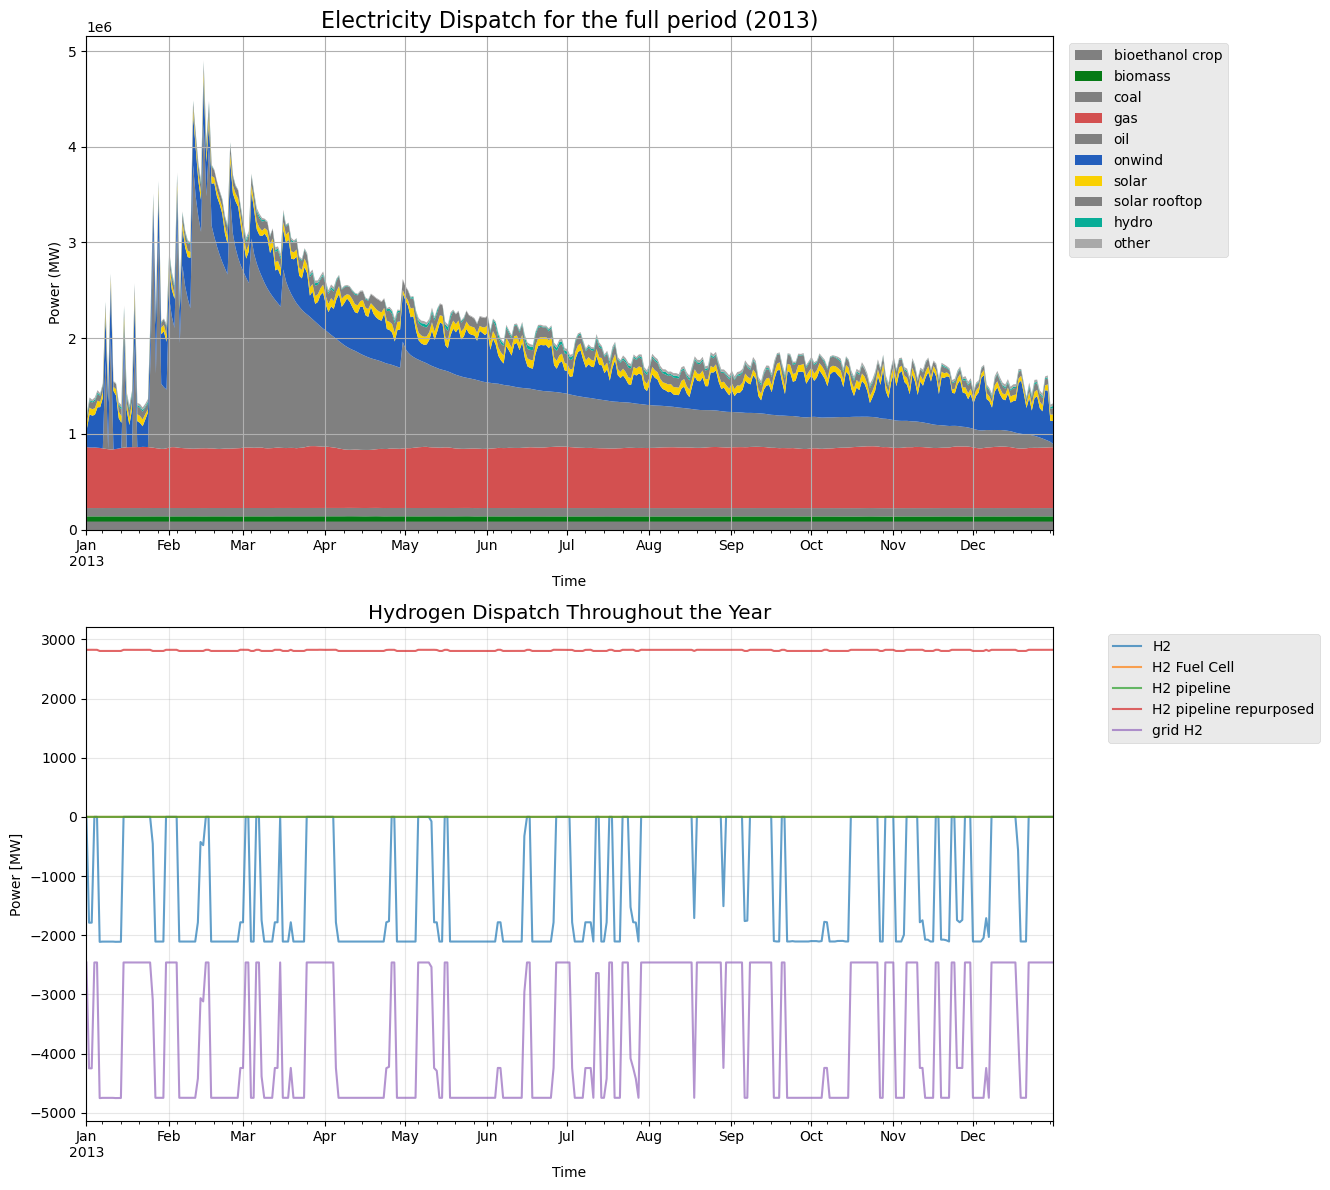

In [ ]:
plot_dispatch(n)

---

## 6. Economic Analysis: What Are the Unit Costs?

*We break down the system costs to find the levelized cost of key energy vectors in different locations.*

### 6.1. Map: Levelized Cost of Electricity (LCOE)
*A map displaying the LCOE at different buses. This shows the all-in cost of producing electricity at various points in the network.*

In [ ]:
shapes = gpd.read_file(region_shapes_path)

In [ ]:
n = attach_region_to_buses(n, region_shapes_path)
n = attach_state_to_buses(n, state_shapes_path)

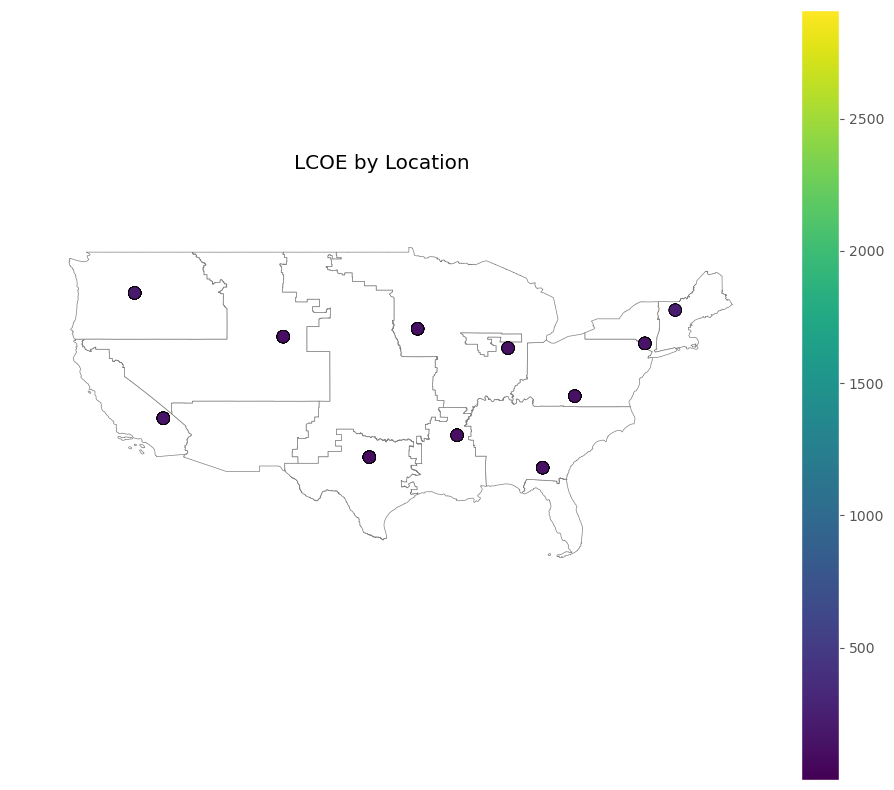

In [ ]:
# Assume: generator has attributes capital_cost, marginal_cost, p_nom_opt, and p (power output time-series)

gen = n.generators
dispatch = n.generators_t.p  # hourly power generation

# Total energy generated (MWh)
energy = dispatch.sum(axis=0) * n.snapshot_weightings.generators.sum() / 1e3  # convert to GWh or MWh if needed

# LCOE = (Annualized Capital + Operating) / Energy
lcoe = (gen.capital_cost * gen.p_nom_opt + gen.marginal_cost * energy) / energy
lcoe = lcoe.replace(np.inf, np.nan).dropna()

gen['lcoe'] = lcoe
lcoe_data = gen[['bus', 'lcoe', 'carrier']]
lcoe_data = lcoe_data.merge(n.buses[['x', 'y']], left_on='bus', right_index=True)
lcoe_data["clean_bus"] = lcoe_data.bus.str.extract(r"(US\d{1} \d{1,2})")
lcoe_data['region'] = lcoe_data.clean_bus.map(n.buses.region)

# Create GeoDataFrame from bus points
geometry = [Point(xy) for xy in zip(lcoe_data['x'], lcoe_data['y'])]
lcoe_gdf = gpd.GeoDataFrame(lcoe_data, geometry=geometry, crs=shapes.crs)
lcoe_gdf = lcoe_gdf.to_crs(shapes.crs)

fig, ax = plt.subplots(figsize=(12, 10))
shapes.plot(ax=ax, color='white', edgecolor='gray')  # Plot the regions

# Scatter LCOE points
lcoe_gdf.plot(
    ax=ax,
    column='lcoe',  # This is the value you're mapping
    cmap='viridis',
    legend=True,
    markersize=80,
    edgecolor='black'
)
plt.xlim([-130, -65])
plt.ylim([20, 55])
plt.title("LCOE by Location")
plt.axis('off')
plt.show()

In [ ]:
lcoe_data.groupby(['region', 'carrier'])['lcoe'].sum().unstack()

carrier       bioethanol crop     biomass       coal          csp        gas  \
region                                                                         
California         109.375441   64.286135   6.897174  1545.657331  16.209318   
Delta              109.376616   64.284489   6.897868  1103.462122  16.208617   
Mid-Atlantic       109.376508   64.285378   6.896601  1490.920905  16.209899   
Midwest            218.752166  128.571459  13.794585  2660.800554  32.418575   
Mountain           109.375974   64.285019   6.897704  1236.956685  16.208748   
New England               NaN   64.285347   0.000000  1720.952167  16.208958   
New York           109.375488   64.285951   6.896887  1646.196812  16.209778   
Northwest          109.376271   64.284388   6.897847  2260.185959  16.209387   
Southeast            0.000000   64.285657   6.897268  1365.007909  16.209544   
Texas              109.376294   64.284780   6.897688  1072.768011  16.208751   

carrier        geothermal  iron ore      nuclear  offwind-ac   offwind-dc  \
region                                                                      
California    1746.951678  0.000000   472.018098         0.0     0.000000   
Delta                 NaN  0.010246   457.786045         0.0  1551.181411   
Mid-Atlantic          NaN  0.009241   411.923871         0.0  2910.793965   
Midwest        480.984878  0.010521   912.396310         0.0     0.000000   
Mountain              NaN  0.000000          NaN         NaN          NaN   
New England           NaN       NaN          NaN         NaN          NaN   
New York              NaN  0.000000   748.263610         0.0  1602.321234   
Northwest      860.922176  0.000000   443.765449         0.0     0.000000   
Southeast             NaN  0.000000   988.135108         0.0  1127.473103   
Texas          468.379068  0.010654  1127.666947         0.0  2525.662648   

carrier       ...       onwind  residential rural solar thermal  \
region        ...                                                 
California    ...   372.081523                       113.197966   
Delta         ...   234.130902                         0.000000   
Mid-Atlantic  ...   862.507952                         0.000000   
Midwest       ...  1090.275746                       197.200235   
Mountain      ...   660.740452                       452.258042   
New England   ...   165.792144                         0.000000   
New York      ...   591.733018                         0.000000   
Northwest     ...   238.998620                       137.742540   
Southeast     ...   146.411286                         0.000000   
Texas         ...  1121.725629                      1455.660312   

carrier       residential urban decentral solar thermal  scrap steel  \
region                                                                 
California                                    79.735114     0.000000   
Delta                                          0.000000     0.000000   
Mid-Atlantic                                   0.000000     0.009770   
Midwest                                      157.667599     0.009069   
Mountain                                     386.840295     0.000000   
New England                                    0.000000          NaN   
New York                                       0.000000     0.000000   
Northwest                                     99.833948     0.000000   
Southeast                                      0.000000     0.000000   
Texas                                       1265.419243     0.000000   

carrier       services rural solar thermal  \
region                                       
California                      113.216817   
Delta                             0.000000   
Mid-Atlantic                      0.000000   
Midwest                         197.180129   
Mountain                        452.262032   
New England                       0.000000   
New York                          0.000000   
Northwest                     

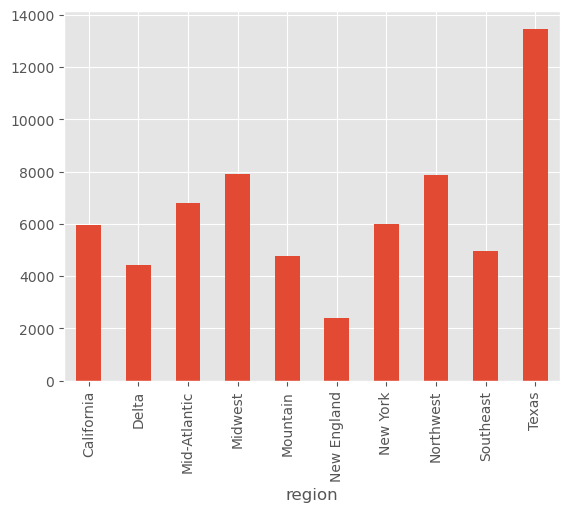

In [ ]:
lcoe_data.groupby("region")["lcoe"].sum().plot(kind='bar')
plt.show()

### 6.2. Map: Levelized Cost of Hydrogen (LCOH)
*A map displaying the LCOH at buses where hydrogen is produced. This is a critical metric for the hydrogen economy.*

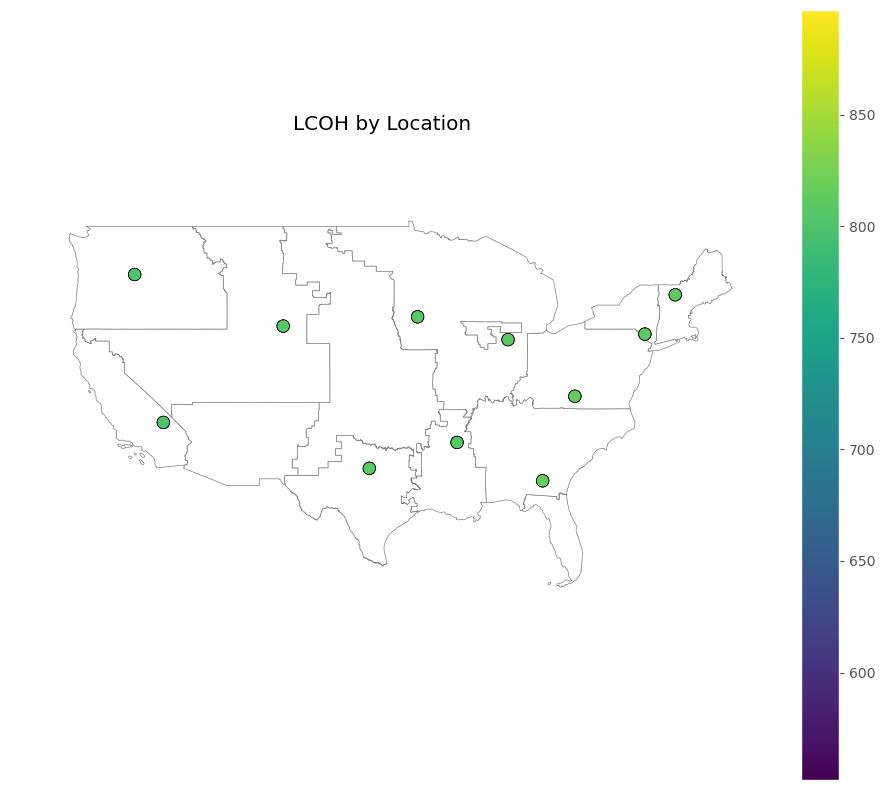

In [ ]:
h2_carriers = ["Alkaline electrolyzer large", "Alkaline electrolyzer medium",
            "Alkaline electrolyzer small", "PEM electrolyzer", "SOEC"]

hydrogen_links = n.links.query("carrier in @h2_carriers")
hydrogen_dispatch = n.links_t.p0[hydrogen_links.index]  # p0 is power input to electrolyzers

# Total H2 energy output: p1 is H2 output
h2_output = -n.links_t.p1[hydrogen_links.index].sum(axis=0)

lcoh = (hydrogen_links.capital_cost * hydrogen_links.p_nom_opt + hydrogen_links.marginal_cost * h2_output) / h2_output

hydrogen_links['lcoh'] = lcoh
lcoh_data = hydrogen_links[['bus0', 'lcoh', 'carrier']]
lcoh_data = lcoh_data.merge(n.buses[['x', 'y']], left_on='bus0', right_index=True)
lcoh_data['region'] = lcoh_data.bus0.map(n.buses.region)

# Create GeoDataFrame from bus points
geometry = [Point(xy) for xy in zip(lcoh_data['x'], lcoh_data['y'])]
lcoh_gdf = gpd.GeoDataFrame(lcoh_data, geometry=geometry, crs=shapes.crs)
lcoh_gdf = lcoh_gdf.to_crs(shapes.crs)

fig, ax = plt.subplots(figsize=(12, 10))
shapes.plot(ax=ax, color='white', edgecolor='gray')  # Plot the regions

# Scatter LCOE points
lcoh_gdf.plot(
    ax=ax,
    column='lcoh',  # This is the value you're mapping
    cmap='viridis',
    legend=True,
    markersize=80,
    edgecolor='black'
)
plt.xlim([-130, -65])
plt.ylim([20, 55])
plt.title("LCOH by Location")
plt.axis('off')
plt.show()

In [ ]:
lcoh_data.groupby(['region', 'carrier'])['lcoh'].sum().unstack()

carrier       Alkaline electrolyzer large  PEM electrolyzer         SOEC
region                                                                  
California                     599.446006        859.636331   801.318133
Delta                          557.855013        878.086525   807.481887
Mid-Atlantic                   572.568145        896.837058   814.181381
Midwest                       1118.597682       1760.661805  1616.178707
Mountain                       556.796503        878.218106   807.592872
New England                    570.725977        889.955601   811.481184
New York                       570.015229        890.541377   811.525947
Northwest                      580.486324        860.176263   802.313857
Southeast                      571.820564        896.602782   814.181860
Texas                          558.504209        879.785405   807.593781

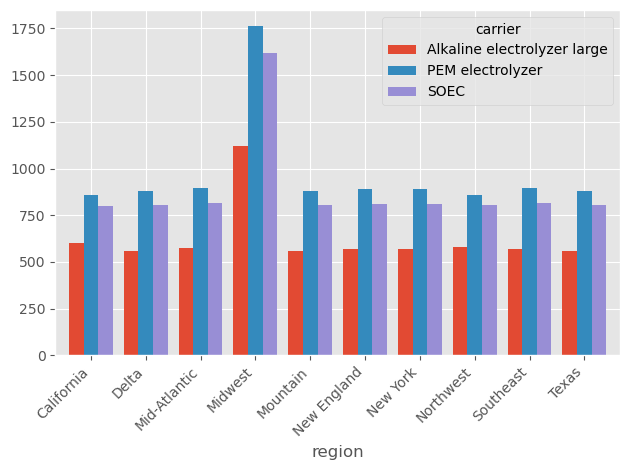

In [ ]:
lcoh_data.groupby(['region', 'carrier'])['lcoh'].sum().unstack().plot(
    kind='bar',
    width=0.8
)
ax.set_ylabel('LCOH')
ax.set_xlabel('Region')
ax.set_title('Levelized Cost of Hydrogen (LCOH) by Region and Electrolyzer Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

---

## 7. Sector-Specific Analysis: E-Kerosene Deep Dive

*A dedicated section to analyze the production chain, costs, and outputs related to synthetic aviation fuel.*

### 7.1. E-Kerosene Production and Costs
*Analysis of the Fischer-Tropsch process, including inputs (H2, CO2), outputs (e-kerosene), and the resulting levelized cost of the fuel.*

In [ ]:
# Code to analyze the FT links, their inputs/outputs,
# and calculate the Levelized Cost of Kerosene (LCOK).
pass

---